In [2]:
# EXPERIMENTAL
# Work in progress (do not use)

# find TC genesis from models based on work similar to FSU's methodology
# Note: uses roughly same thresholds but for different model resolutions, so they are more sensitive than [1]

# only focused on 1. so far:
# [1] https://journals.ametsoc.org/view/journals/wefo/28/6/waf-d-13-00008_1.xml
# [2] https://journals.ametsoc.org/view/journals/wefo/31/3/waf-d-15-0157_1.xml?tab_body=fulltext-display
# [3] https://journals.ametsoc.org/view/journals/wefo/32/1/waf-d-16-0072_1.xml

# for ROCI:
# [4] https://journals.ametsoc.org/view/journals/wefo/28/6/waf-d-13-00008_1.xml

# units are metric, but scale may be mixed between internal representations of data, thresholds, and printouts

# thresholds for disturbances (reversed from text output from FSU)
disturbance_thresholds_path = 'disturbance_thresholds.json'

disturbances_db_file_path = 'disturbances.db'

# this is for accessing by model and timestep
tc_disturbances_db_file_path = 'tc_disturbances.db'
# this is for accessing by model and storm (internal component id)
tc_candidates_db_file_path = 'tc_candidates.db'

# cylindrical (no spherical corrections), same as GEMPAK (used by FSU apparently)
default_vorticity_method = 'metpy'
# metview's vorticity method (differs from metpy/GEPAK):
#vorticity_method = 'metview'

# shape file for placing lat,lon in basins which we are classifying
# each has an attr`ibute called 'basin_name', with CPAC & EPAC combined as EPAC
# basins are NATL, EPAC, WPAC, IO, SH
shape_file = 'shapes/basins.shp'

model_data_folders_by_model_name = {
    'GFS': '/home/db/metview/JRPdata/globalmodeldata/gfs',
    'ECM': '/home/db/metview/JRPdata/globalmodeldata/ecm',
    'CMC': '/home/db/metview/JRPdata/globalmodeldata/cmc',
    'NAV': '/home/db/metview/JRPdata/globalmodeldata/nav'
}

# where to save the disturbance maps
disturbance_maps_folder = '/home/db/Documents/JRPdata/cyclone-genesis/disturbance_maps'

# where to save the disturbance maps
tc_maps_folder = '/home/db/Documents/JRPdata/cyclone-genesis/tc_maps'

# path to font for charts
font_path = '/usr/share/fonts/truetype/freefont/FreeSerif.ttf'

# for debugging MSLP isobars (depth first search)
debug_isobar_images = False

# save vorticity calculations
debug_save_vorticity = False

# output calculation timing for debugging & optimization
debug_calc_exec_time = True

# write networkx graphs (original and reduced) of TC tracks (in graphs/ folder)
write_graphs = True

graphs_folder = '/home/db/Documents/JRPdata/cyclone-genesis/graphs'

# save disturbance maps
save_disturbance_maps = True

# save disturbance maps
save_tc_maps = True


In [3]:
# use cgroup (cgroup-tools) to set memory limit as percentage of memory
# add 3 lines to sudoers (use * in place of params), make sure to escape colons

import os
import subprocess
percent_memory_limit = 30
pid = os.getpid()

total_memory = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')
memory_limit = int(total_memory * percent_memory_limit / 100)
cg_cmd = "sudo /usr/bin/cgcreate -g memory:mygroup"
subprocess.run(cg_cmd, shell=True)
move_notebook_to_cg_cmd = f"sudo /usr/bin/cgclassify -g memory:mygroup {pid}"
subprocess.run(move_notebook_to_cg_cmd, shell = True)
set_memory_limit_cmd = f"sudo /usr/bin/cgset -r memory.limit_in_bytes={memory_limit} memory:mygroup"
subprocess.run(set_memory_limit_cmd, shell = True)

CompletedProcess(args='sudo /usr/bin/cgset -r memory.limit_in_bytes=5006431027 memory:mygroup', returncode=0)

In [4]:
import json
import pygrib
import re
import math
from metpy.units import units
import metpy.constants as mpconst
import metpy.calc as mpcalc
import numpy as np
import pyproj
import geopandas as gpd
from shapely.geometry import Point

import traceback
import sys
import copy
import time
import os

import warnings

import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta
import sqlite3

from matplotlib.patches import Circle

# for generating charts of disturbances
from IPython.display import display, clear_output

from ipyleaflet import Map, GeoJSON, LayersControl, Icon, basemaps, basemap_to_tiles, LayerGroup, FullScreenControl, LegendControl, ImageOverlay, WidgetControl, GeoJSON
from PIL import Image, ImageDraw, ImageFont
from ipywidgets import Text, HTML, Layout

import io
import base64

import metview as mv
import xarray as xr

import networkx as nx
import matplotlib.pyplot as plt
from pyproj import Geod

# may need to modify lzma.py in python folder to get this to work (pip install backports-lzma)
# this is for metpy
try:
    import lzma
except ImportError:
    import backports.lzma as lzma

gdf = gpd.read_file(shape_file)

disturbance_criteria_names_map = {
    'WS': 'vmax925',
    'THKN': 'gp250_850_thickness',
    'RV': 'rv850max'
}

# shape file attribute names to threshold names
shape_basin_names_to_threshold_names_map = {
    'NATL': 'AL',
    'WPAC': 'WP',
    'IO': 'IO',
    'SH': 'SH',
    'EPAC': 'EP'
}

model_time_step_str_format = {
    'GFS': '03',
    'ECM': '00',
    'CMC': '03',
    'NAV': '03'
}

# not including GFS analysis files (.anl)
total_model_time_steps = {
    'GFS': {
        '00': 65,
        '06': 65,
        '12': 65,
        '18': 65
    },
    'ECM': {
        '00': 41,
        '12': 41
    },
    'CMC': {
        '00': 41,
        '12': 41
    },
    'NAV': {
        '00': 31,
        '06': 31,
        '12': 31,
        '18': 31
    }
}
# only interested in 6 hour time steps
all_time_steps_by_model = {
    'GFS': {
        '00': [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228, 234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306, 312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384],
        '06': [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228, 234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306, 312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384],
        '12': [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228, 234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306, 312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384],
        '18': [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228, 234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306, 312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384]
        },
    'ECM': {
        '00': [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228, 234, 240],
        '12': [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228, 234, 240]
    },
    'CMC': {
        '00': [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228, 234, 240],
        '12': [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228, 234, 240]
    },
    'NAV': {
        '00': [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 174, 180],
        '06': [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 174, 180],
        '12': [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 174, 180],
        '18': [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 174, 180]
    }
}

# NAVGEM has relative vorticity grib (if using USGODAE); if using NCEP we need the u/v wind speed gribs for 850
# NCEP might be faster for NAVGEM (and for consistency of vorticity calculations, calculate it ourselves)
expected_num_grib_files_by_model_name = {
    'GFS': 9,
    'CMC': 9,
    'ECM': 9,
    'NAV': 9,
    'UKM': 9
}

# in order to select grib files from a folder we need to ignore these file name extensions
ignored_file_extensions = [
    'asc',
    'idx',
    'json',
    'index'
]

# hours between model runs
model_interval_hours = {
    'GFS': 6,
    'ECM': 12,
    'CMC': 12,
    'NAV': 6
}

time_step_re_str_by_model_name = {
    'GFS': r'.*?\.f(?P<time_step>\d\d\d)_',
    'ECM': r'.*?-(?P<time_step>\d+)h-oper-fc',
    'CMC': r'.*?\d+_P(?P<time_step>\d+)',
    'NAV': r'.*?navgem_\d{10}f(?P<time_step>\d\d\d)'
}

with open(disturbance_thresholds_path, 'r') as f:
    disturbance_thresholds = json.loads(f.read())

colocated_box_radii = [5]
next_colocated_box_radii = [3]
largest_colocated_radius = colocated_box_radii[-1]
largest_next_colocated_radius = next_colocated_box_radii[-1]
# edges between nodes in same timestep (box of colocated radius degrees)
largest_colocated_edge_type = f'colocated_{largest_colocated_radius}'
# these are edges to the next timestep
next_colocated_edge_type = f'next_colocated_{largest_next_colocated_radius}'
# colors for nx graphs (disjoint segments are 'split' and colored red)
nx_default_color = 'skyblue'
nx_split_color = 'red'
    
# must set to [] anywhere there is an exception and the stack doesn't get popped properly
debug_time_start_stack = []

# Reset the warnings to its original state here
warnings.resetwarnings()

# close old maps generated
old_maps = []

old_tc_maps = []

meters_to_knots = 1.943844

In [5]:
# get list of completed TC candidates (tracks)
def get_tc_candidates_by_basin(basin_name, limit=10):
    all_retrieved_data = []  # List to store data from all rows
    conn = None
    try:
        # Connect to the SQLite database
        conn = sqlite3.connect(tc_candidates_db_file_path)
        cursor = conn.cursor()

        # Query all rows from the 'disturbances' table and order by 'model_timestamp'
        cursor.execute('SELECT model_name, init_date, start_valid_date, ws_max_10m, data FROM tc_candidates WHERE start_basin = ? ORDER BY init_date DESC LIMIT ?', (basin_name, limit))
        results = cursor.fetchall()
        if results:
            # Process data for each row
            for row in results:
                model_name, init_date, start_valid_date, ws_max_10m, json_data = row
                retrieved_data = {
                    "model_name": model_name,
                    "model_timestamp": init_date,
                    "start_valid_time": start_valid_date,
                    "ws_max_10m": ws_max_10m,
                    "disturbance_candidates": json.loads(json_data)
                }
                all_retrieved_data.append(retrieved_data)

    except sqlite3.Error as e:
        print(f"SQLite error (get_tc_candidates_by_basin): {e}")
    finally:
        if conn:
            conn.close()

    return all_retrieved_data

def max_model_time_steps_from_timestamp_str(model_name, timestamp_str):
    dt = datetime.fromisoformat(timestamp_str)
    hour = dt.hour
    hour_str = f'{hour:02}'
    return all_time_steps_by_model[model_name][hour_str][-1]

# get list of completed TC candidates (tracks)
def get_tc_candidates_from_last_n_model_init_times(num_init_times=1):
    all_retrieved_data = []  # List to store data from all rows
    conn = None
    model_names = list(model_data_folders_by_model_name.keys())
    model_init_times = {}
    try:
        # Connect to the SQLite database
        conn = sqlite3.connect(tc_candidates_db_file_path)
        cursor = conn.cursor()

        for model_name in model_names:
            cursor.execute('SELECT DISTINCT init_date FROM completed WHERE model_name = ? ORDER BY init_date DESC LIMIT ?', (model_name, num_init_times))
            results = cursor.fetchall()
            recent_model_init_times = []
            if results:
                for row in results:
                    init_time = row[0]
                    recent_model_init_times.append(init_time)
                    if model_name not in model_init_times:
                        model_init_times[model_name] = []

                for init_date in recent_model_init_times:
                    model_init_times[model_name].append(init_date)
                    # Query all rows from the 'disturbances' table and order by 'model_timestamp'
                    cursor.execute('SELECT model_name, init_date, start_valid_date, ws_max_10m, data FROM tc_candidates WHERE model_name = ? AND init_date = ? ORDER BY init_date DESC', (model_name, init_date))
                    results = cursor.fetchall()
                    if results:
                        # Process data for each row
                        for row in results:
                            model_name, init_date, start_valid_date, ws_max_10m, json_data = row
                            retrieved_data = {
                                "model_name": model_name,
                                "model_timestamp": init_date,
                                "start_valid_time": start_valid_date,
                                "ws_max_10m": ws_max_10m,
                                "disturbance_candidates": json.loads(json_data)
                            }
                            all_retrieved_data.append(retrieved_data)

    except sqlite3.Error as e:
        print(f"SQLite error (get_tc_candidates_from_last_n_model_init_times): {e}")
    finally:
        if conn:
            conn.close()

    return model_init_times, all_retrieved_data

############################################################
########   CHART DISTURBANCES & CYCLONE CANDIDATES  ########
############################################################

def get_title_overlay(title_text):
    # Create a blank image with a white background
    width, height = 360, 360
    image = Image.new('RGBA', (width, height), (255, 255, 255, 0))

    # Create a drawing context
    draw = ImageDraw.Draw(image)

    # Define the text and font
    font_size = 28
    font = ImageFont.truetype(font_path, font_size)

    # Calculate the bounding box of the text
    text_bbox = draw.textbbox((0,0), title_text, font=font, align='center')

    # Calculate the position to center the text vertically
    x_min, y_min, x_max, y_max = text_bbox
    x = (width - (x_max - x_min)) // 2
    y = (height - (y_max - y_min)) // 2

    # Increase the size of the rectangle to add more space around the text
    padding = 10  # Adjust this value to control the size of the rectangle
    rectangle_x0 = x - padding
    rectangle_y0 = y - padding
    rectangle_x1 = x_max + x + padding
    rectangle_y1 = y_max + y + padding

    # Fill the background with a white rectangle
    draw.rectangle([rectangle_x0, rectangle_y0, rectangle_x1, rectangle_y1], fill=(255, 255, 255, 255))

    # Add a thin red border
    border_width = 1
    draw.rectangle([rectangle_x0, rectangle_y0, rectangle_x1, rectangle_y1], outline=(255, 0, 0, 255), width=border_width)

    # Draw the text on the image
    draw.multiline_text((x, y), title_text, font=font, fill=(0, 0, 0, 255))  # Black text

    # Convert the PIL image to bytes
    image_bytes = io.BytesIO()
    image.save(image_bytes, format='PNG')
    image_data = image_bytes.getvalue()
    image_bytes.close()

    # Encode the image data in base64
    image_base64 = base64.b64encode(image_data).decode()

    # Create a data URI for the image
    image_data_uri = f"data:image/png;base64,{image_base64}"

    # Calculate the bounds for the ImageOverlay
    bounds = [(8,40), (72,130)]

    # Create an ImageOverlay with the data URI for the image and calculated bounds
    title_overlay = ImageOverlay(
        name='Title',
        url=image_data_uri,
        bounds=bounds  # Use the calculated bounds
    )
    return title_overlay

def generate_tc_chart(tc_candidates):
    def update_html(feature, **kwargs):
        html1.value = '''
            <div id='DISTURBANCE_PROPS'>
            <p>Model: {}</p>
            <p>Init Time: {}</p>
            <p>Valid Time: {}</p>
            <p>Time step (h): +{}</p>
            <p>Lat, Lon: {}, {}</p>
            <p>ROCI (km): {}</p>
            <p>Isobar Delta (hPa)): {}</p>
            <p>MSLP (hPa): {}</p>
            <p>Vmax (m/s) @ 10m: {}</p>
            </div>
        '''.format(
            feature['properties']['model_name'],
            feature['properties']['init_time'],
            feature['properties']['valid_time'],
            feature['properties']['time_step'],
            feature['properties']['lat'], feature['properties']['lon'],
            feature['properties']['roci'],
            feature['properties']['closed_isobar_delta'],
            feature['properties']['mslp_value'],
            feature['properties']['vmax10m_in_roci']
        )

    for m in old_tc_maps:
        m.close()
        m.close_all()
    
    lat_lon_with_time_step_list = []
    most_recent_timestamp = None
    for tc in tc_candidates:
        model_name = tc['model_name']
        model_timestamp = tc['model_timestamp']
        disturbance_candidates = tc['disturbance_candidates']    
        if not most_recent_timestamp:
            most_recent_timestamp = model_timestamp
        if disturbance_candidates:
            prev_lat = None
            prev_lon = None
            prev_lon_repeat2 = None
            prev_lon_repeat3 = None
            for time_step_str, valid_time_str, candidate in disturbance_candidates:
                time_step_int = int(time_step_str)
                lon = candidate['lon']
                candidate_info = {}
                candidate_info['model_name'] = model_name
                candidate_info['init_time'] = model_timestamp
                candidate_info['lat'] = f"{candidate['lat']:3.2f}"
                candidate_info['lon'] = f"{lon:3.2f}"
                candidate_info['lon_repeat'] = candidate_info['lon']
                candidate_info['valid_time'] = valid_time_str
                candidate_info['time_step'] = time_step_int
                candidate_info['roci'] = f"{candidate['roci']/1000:3.1f}"
                candidate_info['vmax10m_in_roci'] = f"{candidate['vmax10m_in_roci']:3.2f}"
                candidate_info['closed_isobar_delta'] = candidate['closed_isobar_delta']
                candidate_info['mslp_value'] = f"{candidate['mslp_value']:4.1f}"

                if prev_lon:
                    prev_lon_f = float(prev_lon)
                    if abs(prev_lon_f - lon) > 270:
                        if prev_lon_f < lon:
                            prev_lon = f"{prev_lon_f + 360:3.2f}"
                        else:
                            prev_lon = f"{prev_lon_f - 360:3.2f}"

                candidate_info['prev_lat'] = prev_lat
                candidate_info['prev_lon'] = prev_lon
                candidate_info['prev_lon_repeat'] = prev_lon

                prev_lat = candidate_info['lat']
                prev_lon = lon
                prev_lon_repeat1 = lon
                
                lat_lon_with_time_step_list.append(candidate_info)
                # add copies to extend the map left and right
                ccopy = candidate_info.copy()
                lon_repeat2 = lon - 360
                ccopy['lon_repeat'] = f"{lon_repeat2:3.2f}"
                if prev_lon_repeat2:
                    prev_lon_repeat2_f = float(prev_lon_repeat2)
                    if abs(prev_lon_repeat2_f - lon_repeat2) > 270:
                        if prev_lon_repeat2_f < lon_repeat2:
                            prev_lon_repeat2 = f"{prev_lon_repeat2_f + 360:3.2f}"
                        else:
                            prev_lon_repeat2 = f"{prev_lon_repeat2_f - 360:3.2f}"

                ccopy['prev_lon_repeat'] = prev_lon_repeat2
                prev_lon_repeat2 = ccopy['lon_repeat']

                lat_lon_with_time_step_list.append(ccopy)
                ccopy = candidate_info.copy()
                lon_repeat3 = lon + 360
                ccopy['lon_repeat'] = f"{lon_repeat3:3.2f}"
                if prev_lon_repeat3:
                    prev_lon_repeat3_f = float(prev_lon_repeat3)
                    if abs(prev_lon_repeat3_f - lon_repeat3) > 270:
                        if prev_lon_repeat3_f < lon_repeat3:
                            prev_lon_repeat3 = f"{prev_lon_repeat3_f + 360:3.2f}"
                        else:
                            prev_lon_repeat3 = f"{prev_lon_repeat3_f - 360:3.2f}"

                ccopy['prev_lon_repeat'] = prev_lon_repeat3
                prev_lon_repeat3 = ccopy['lon_repeat']

                lat_lon_with_time_step_list.append(ccopy)

    # Create the initial map
    # darkmatter is dark, positron is light
    # CartoDB.DarkMatter
    # CartoDB.Positron
    darkmatter = basemap_to_tiles(basemaps.CartoDB.DarkMatter)
    darkmatter.base = True
    darkmatter.name = 'Dark'

    positron = basemap_to_tiles(basemaps.CartoDB.Positron)
    positron.base = True
    positron.name = 'Light'

    layout=Layout(height='800px')
    
    m = Map(center=(0, 200), zoom=1.5, layout=layout, layers=[positron, darkmatter])

    html1 = HTML(
    '''
    <div id='DISTURBANCE_PROPS'>
    <h4>Disturbance Info:</h4>
    Mouse hover over a point</div>
    '''
    )
    html1.layout.margin = '0px 20px 20px 20px'

    control1 = WidgetControl(widget=html1, position='bottomright')
    m.add(control1)
    
    #model_date = datetime.strftime(model_timestamp, '%Y-%m-%d')
    #model_hour = f'{model_timestamp.hour:02}'
    title_text = f'TC candidate tracks\nLast : {model_timestamp[:-6]}'
    
    m.add(get_title_overlay(title_text))
    
    colors = ['red', 'yellow', 'springgreen', 'darkturquoise', 'blue', 'orchid']
    
    # Define 6 different time_step ranges and their corresponding colors
    time_step_ranges = [
        (0, 48),
        (49, 120),
        (121, 168),
        (169, 240),
        (241, 336),
        (337, float('inf'))  # Anything larger than 57
    ]

    range_str = [
        '2d',
        '5d',
        '7d',
        '10d',
        '14d',
        '14+d'
    ]

    # Create a LegendControl with color names
    legend = LegendControl(
        {
            "2 days": "red",
            "5 days": "yellow",
            "7 days": "springgreen",
            "10 days": "darkturquoise",
            "14 days": "blue",
            "14+ days": "orchid"
        },
        title="Days+Init",
        position="bottomleft"
    )

    # Create custom marker styles and feature collections for each time_step range
    custom_marker_styles = []
    feature_collections = []
    layer_groups = []

    # do in reversed order so most recent items get rendered on top
    for i, (start, end) in reversed(list(enumerate(time_step_ranges))):
        style = {
            'color': colors[i],
            'fill': True,
            'fillColor': colors[i],
            'opacity': 0.6,
            'radius': 1  # Adjust the radius as needed
        }
        custom_marker_styles.append(style)

        features = []
        for point in reversed(lat_lon_with_time_step_list):
            time_step = point['time_step']
            if start <= time_step <= end:
                feature = {
                    'type': 'Feature',
                    'geometry': {
                        'type': 'Point',
                        'coordinates': [point['lon_repeat'], point['lat']]
                    },
                    'properties': point
                }

                features.append(feature)

        name = f'{range_str[i]}'
        feature_collection = GeoJSON(data={
            'type': 'FeatureCollection',
            'features': features
        }, point_style=style)
        feature_collection.on_hover(update_html)
        feature_collections.append(feature_collection)

        layer_group = LayerGroup(layers=(feature_collection,), name=name)
        layer_groups.append(layer_group)
        m.add(layer_group)

        
    # Create custom marker styles and feature collections for each time_step range
    custom_marker_styles = []
    feature_collections = []
    layer_groups = []

    # do in reversed order so most recent items get rendered on top
    for i, (start, end) in reversed(list(enumerate(time_step_ranges))):
        style = {
            'color': colors[i],
            'fill': True,
            'fillColor': colors[i],
            'opacity': 0.2,
            'stroke-width': 7,
            'strokeWidth': 9,
            'strokewidth': 11,
            'width': 13
        }
        custom_marker_styles.append(style)

        features = []
        for point in reversed(lat_lon_with_time_step_list):
            time_step = point['time_step']
            if start <= time_step <= end:
                if point['prev_lon_repeat']:
                    feature = {
                        "type": "Feature",
                        "geometry": {
                            "type": "LineString",
                            "coordinates": [
                                [point['prev_lon_repeat'], point['prev_lat']], [point['lon_repeat'], point['lat']]
                                ]
                        }
                    }
                    features.append(feature)

        name = 'Tracks'
        feature_collection = GeoJSON(data={
            'type': 'FeatureCollection',
            'features': features
        }, style=style)
        feature_collections.append(feature_collection)

        layer_group = LayerGroup(layers=(feature_collection,), name=name)
        layer_groups.append(layer_group)
        m.add(layer_group)
        
    # Add legend to the map
    m.add(legend)
    m.add(LayersControl())
    m.add(FullScreenControl())
    
    # Display the interactive map
    clear_output()
    display(m)

    old_tc_maps.append(m)
    
    # save the map if wanted
    if save_tc_maps:
        file_name = f'{model_timestamp}.html'
        save_file_path = os.path.join(tc_maps_folder, file_name)
        m.save(save_file_path)

def generate_disturbances_chart(model_name, model_timestamp, time_steps):
    def update_html(feature, **kwargs):
        html1.value = '''
            <div id='DISTURBANCE_PROPS'>
            <p>Time step (h): +{}</p>
            <p>Lat, Lon: {}, {}</p>
            <p>ROCI (km): {}</p>
            <p>Isobar Delta (hPa)): {}</p>
            <p>MSLP (hPa): {}</p>
            <p>Vmax (m/s) @ 10m: {}</p>
            </div>
        '''.format(
            feature['properties']['time_step'],
            feature['properties']['lat'], feature['properties']['lon'],
            feature['properties']['roci'],
            feature['properties']['closed_isobar_delta'],
            feature['properties']['mslp_value'],
            feature['properties']['vmax10m_in_roci']
        )

    for m in old_maps:
        m.close()
        m.close_all()
        
    disturbance_candidates = get_disturbances_from_db(model_name, model_timestamp)
    lat_lon_with_time_step_list = []
    if disturbance_candidates:
        for time_step_str, candidates in disturbance_candidates.items():
            time_step_int = int(time_step_str)
            dt = model_timestamp + timedelta(hours=time_step_int)
            for candidate in candidates:
                candidate_info = {}
                candidate_info['lat'] = candidate['lat']
                candidate_info['lon'] = candidate['lon']
                candidate_info['lon_repeat'] = candidate['lon']
                candidate_info['time_step'] = time_step_int
                candidate_info['roci'] = f"{candidate['roci']/1000:3.1f}"
                candidate_info['vmax10m_in_roci'] = f"{candidate['vmax10m_in_roci']:3.2f}"
                candidate_info['closed_isobar_delta'] = candidate['closed_isobar_delta']
                candidate_info['mslp_value'] = f"{candidate['mslp_value']:4.1f}"
                
                lat_lon_with_time_step_list.append(candidate_info)
                # add copies to extend the map left and right
                lon = candidate['lon']
                ccopy = candidate_info.copy()
                ccopy['lon_repeat'] = lon - 360
                lat_lon_with_time_step_list.append(ccopy)
                ccopy = candidate_info.copy()
                ccopy['lon_repeat'] = lon + 360
                lat_lon_with_time_step_list.append(ccopy)

    # Create the initial map
    # darkmatter is dark, positron is light
    # CartoDB.DarkMatter
    # CartoDB.Positron
    darkmatter = basemap_to_tiles(basemaps.CartoDB.DarkMatter)
    darkmatter.base = True
    darkmatter.name = 'Dark'

    positron = basemap_to_tiles(basemaps.CartoDB.Positron)
    positron.base = True
    positron.name = 'Light'

    m = Map(center=(0, 200), zoom=1.5, layers=[positron, darkmatter])

    html1 = HTML(
    '''
    <div id='DISTURBANCE_PROPS'>
    <h4>Disturbance Info:</h4>
    Mouse hover over a point</div>
    '''
    )
    html1.layout.margin = '0px 20px 20px 20px'

    control1 = WidgetControl(widget=html1, position='bottomright')
    m.add(control1)
    
    model_date = datetime.strftime(model_timestamp, '%Y-%m-%d')
    model_hour = f'{model_timestamp.hour:02}'
    title_text = f'{model_date} {model_hour}Z\n{model_name} - Disturbances'
    
    m.add(get_title_overlay(title_text))
    
    colors = ['red', 'yellow', 'springgreen', 'darkturquoise', 'blue', 'orchid']
    
    # Define 6 different time_step ranges and their corresponding colors
    time_step_ranges = [
        (0, 48),
        (49, 120),
        (121, 168),
        (169, 240),
        (241, 336),
        (337, float('inf'))  # Anything larger than 57
    ]

    range_str = [
        '2d',
        '5d',
        '7d',
        '10d',
        '14d',
        '14+d'
    ]

    # Create a LegendControl with color names
    legend = LegendControl(
        {
            "2 days": "red",
            "5 days": "yellow",
            "7 days": "springgreen",
            "10 days": "darkturquoise",
            "14 days": "blue",
            "14+ days": "orchid"
        },
        title="Days+Init",
        position="bottomright"
    )

    # Create custom marker styles and feature collections for each time_step range
    custom_marker_styles = []
    feature_collections = []
    layer_groups = []

    # do in reversed order so most recent items get rendered on top
    for i, (start, end) in reversed(list(enumerate(time_step_ranges))):
        style = {
            'color': colors[i],
            'fill': True,
            'fillColor': colors[i],
            'opacity': 0.6,
            'radius': 1  # Adjust the radius as needed
        }
        custom_marker_styles.append(style)

        features = []
        for point in reversed(lat_lon_with_time_step_list):
            time_step = point['time_step']
            if start <= time_step <= end:
                feature = {
                    'type': 'Feature',
                    'geometry': {
                        'type': 'Point',
                        'coordinates': [point['lon_repeat'], point['lat']]
                    },
                    'properties': point
                }
                features.append(feature)

        name = f'{range_str[i]}'
        feature_collection = GeoJSON(data={
            'type': 'FeatureCollection',
            'features': features
        }, point_style=style)
        feature_collection.on_hover(update_html)
        feature_collections.append(feature_collection)

        layer_group = LayerGroup(layers=(feature_collection,), name=name)
        layer_groups.append(layer_group)
        m.add(layer_group)

    # Add legend to the map
    m.add(legend)
    m.add(LayersControl())
    m.add(FullScreenControl())
    
    # Display the interactive map
    clear_output()
    display(m)
    
    # save the map if wanted
    if save_disturbance_maps:
        file_name = f'{model_name}_{model_date}_{model_hour}Z.html'
        save_file_path = os.path.join(disturbance_maps_folder, file_name)
        m.save(save_file_path)
        
    old_maps.append(m)

#########################################################
########       CALCULATE DISTURBANCES            ########
#########################################################

def traverse_contour(grid):    
    x_lookup = [0,1,0,-1]
    y_lookup = [-1,0,1,0]

    grid_shape = np.shape(grid)
    visited = np.zeros(grid_shape, dtype=bool)
    
    y_last = grid_shape[0] - 1
    x_last = grid_shape[1] - 1

    center_y = grid_shape[0] // 2
    center_x = grid_shape[1] // 2

    north_stack = []
    south_stack = []
    east_stack = []
    west_stack = []
    cardinal_stacks = [north_stack, east_stack, south_stack, west_stack]

    for direction in range(4):
        y = center_y
        x = center_x
        
        current_stack = cardinal_stacks[direction]
        stack2 = []
        
        found_isosurface = False
        reached_ends = False
        while True:
            visited[y][x] = True
            if not grid[y][x]:
                last_direction = (direction-1)%4
                new_y = y + y_lookup[last_direction]
                new_x = x + x_lookup[last_direction]
                if (0 <= new_y <= y_last) and (0 <= new_x <= x_last):
                    current_stack.append((last_direction, new_y, new_x))
                    
                last_direction = (direction+1)%4
                new_y = y + y_lookup[last_direction]
                new_x = x + x_lookup[last_direction]
                if (0 <= new_y <= y_last) and (0 <= new_x <= x_last):
                    stack2.append((last_direction, new_y, new_x))
                
                new_y = y + y_lookup[direction]
                new_x = x + x_lookup[direction]
                if (0 <= new_y <= y_last) and (0 <= new_x <= x_last) and not visited[new_y][new_x]:
                    y = new_y
                    x = new_x
                else:
                    reached_bounds = True
                    break
            else:
                found_isosurface = True
                break
        
        if (not found_isosurface) and reached_bounds:
            return False
                
        current_stack.extend(stack2)

    while(north_stack or south_stack or east_stack or west_stack):
        for stack in cardinal_stacks:
            if stack:
                last_direction, y, x = stack.pop()
                if visited[y][x]:
                    continue

                visited[y][x] = True
                if not grid[y][x]:
                    if (y == 0) or (x == 0) or (y == y_last) or (x == x_last):
                        return False

                    for neighbor_direction in [(last_direction + 1) % 4, last_direction, (last_direction - 1) % 4]:
                        neighbor_y = y + y_lookup[neighbor_direction]
                        neighbor_x = x + x_lookup[neighbor_direction]
                        if (0 <= neighbor_y <= y_last) and (0 <= neighbor_x <= x_last):
                            if not visited[neighbor_y][neighbor_x]:
                                stack.append((neighbor_direction, neighbor_y, neighbor_x))

    return True

# checks for a closed isobar (not at integer steps) using traverse_contour
# this will only return True or False, as opposed to the dfs version (which finds the contour)
#    this is since the visited is not the contour of the isosurface because of the search method
def has_closed_isobar_traverse_contour(mslp_data, grid_resolution, candidate, isobar_threshold=2.0, isobar_search_radius_degrees = 15):
    isobar_neighborhood_size = calculate_neighborhood_size(isobar_search_radius_degrees, grid_resolution)

    try:
        x = candidate['x_value']
        y = candidate['y_value']
        minima_value = mslp_data[x][y]

        # Create a modified neighborhood for isobar calculation

        x_min = x - isobar_neighborhood_size
        x_max = x + isobar_neighborhood_size + 1
        y_min = y - isobar_neighborhood_size
        y_max = y + isobar_neighborhood_size + 1

        in_bounds = ((x_min >= 0) and
            (x_max <= mslp_data.shape[0]) and
            (y_min >= 0) and
            (y_max <= mslp_data.shape[1]))

        if in_bounds:
            # the normal case (not edges of array)
            neighborhood = mslp_data[x_min:x_max, y_min:y_max]
        else:
            # handle indices at the boundaries
            neighborhood = extract_2d_neighborhood(mslp_data, (x, y), isobar_neighborhood_size)
        
        # create a binary image (True are values that are at the threshold, with the center being False)
        binary_neighborhood = (neighborhood - minima_value - isobar_threshold) >= 0

        return traverse_contour(binary_neighborhood)

    except Exception as e:
        print(f"Error: {e}")
        traceback.print_exc(limit=None, file=None, chain=True)
        return None

# finds a closed isobar (not at integer steps) using dfs
# this will return a visited array of the neighborhood
#  the visited are those values less than the isobar_threshold difference from the center enclosed by an isoline
#  if there is no closed isobar within the neighborhood it will return None
# this is modified from previous version, so takes the (float) neighborhood as input, along with the center minima value, radius, and threshold from minima
def find_closed_isobar_in_neighborhood(neighborhood, minima_value, isobar_neighborhood_size, isobar_threshold = 2.0):
    def dfs(x, y):
        nonlocal visited
        stack = [(x, y)]

        while stack:
            x, y = stack.pop()
            visited[x][y] = True

            # Check N, S, E, W neighbors
            neighbors = [(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1)]

            for nx, ny in neighbors:
                if 0 <= nx < isobar_neighborhood_size * 2 + 1 and 0 <= ny < isobar_neighborhood_size * 2 + 1:
                    if not visited[nx][ny]:
                        if nx == 0 or ny == 0 or nx == isobar_neighborhood_size * 2 or ny == isobar_neighborhood_size * 2:
                            return False
                        if not binary_neighborhood[nx][ny]:
                            stack.append((nx, ny))
        return True

    try:
        # create a binary image (True are values that are at the threshold, with the center being False)
        binary_neighborhood = (neighborhood - minima_value - isobar_threshold) >= 0

        # Initialize visited array for DFS
        visited = np.zeros_like(binary_neighborhood, dtype=bool)

        # Flag to track if a closed path is found
        path_found = dfs(isobar_neighborhood_size, isobar_neighborhood_size)

        if path_found:
            return copy.deepcopy(visited)
        else:
            return None

    except Exception as e:
        print(f"Error: {e}")
        traceback.print_exc(limit=None, file=None, chain=True)
        return None

# todo remove other storms?
# only for finding disturbance center 'mass' coordinate, similar to [4]
def find_feature_center(neighborhood):
    # Find the center of the feature (assuming it's connected)
    float_x, float_y = np.argwhere(neighborhood).mean(axis=0)
    return (int(round(float_x)), int(round(float_y)))

# this is different than [4] (closed isobar where all radial legs are met)
# this allows for a closed isobar that is not perfectly round, extending outward up until before the isobar is no longer closed (above the threshold)
# each leg is extended to the radius used to create the neighborhood (15 deg or ~1667 km)
# [4] legs extends to 1500km (~13.3 deg)
def find_average_radius(mslp_fs, candidate, neighborhood, num_legs=576):
    # Get the center of the neighborhood
    neighborhood_center = (neighborhood.shape[0] // 2, neighborhood.shape[1] // 2)
    
    # need to get distances from mass center in mslp_data
    # use mv.distance and mslp_fs to do so
    # todo? this can likely be optimized further
    mslp_ds = mslp_fs.to_dataset()
    mv_lats = mslp_ds.latitude.to_numpy()
    mv_lons = mslp_ds.longitude.to_numpy()
    mass_x = candidate['mass_x']
    mass_y = candidate['mass_y']
    mass_lat, mass_lon = array_indices_to_lat_lon(mass_x, mass_y, mv_lats, mv_lons)
    dist_fs = mslp_fs.distance(mass_lat, mass_lon)
    distances_ds = dist_fs.to_dataset()
    if type(distances_ds) is not np.ndarray:
        for var in distances_ds:
            if 'msl' in var:
                distances = distances_ds[var].to_numpy()
                break
    else:
        distances = distances_ds
    
    # Calculate the angle step between legs
    angle_step = 2 * np.pi / num_legs
    
    # Initialize a list to store distances for each leg (meters)
    leg_distances = []
    # also store in units of grid_resolution
    leg_distances_units = []
    
    for i in range(num_legs):
        # Calculate the direction vector for the current leg
        direction = np.array([np.cos(i * angle_step), np.sin(i * angle_step)])
        
        # Initialize the leg distance
        leg_distance_units = 0
        
        current_point = copy.deepcopy(neighborhood_center)
        neighborhood_last_x = neighborhood_center[0]
        neighborhood_last_y = neighborhood_center[1]
        while True:
            current_point = current_point + direction
            x, y = current_point.astype(int)
            
            # Check if the current point is out of bounds or False
            if x < 0 or x >= neighborhood.shape[0] or y < 0 or y >= neighborhood.shape[1] or not neighborhood[x, y]:
                break
            
            # Increment the leg distance
            leg_distance_units += 1
            neighborhood_last_x = x
            neighborhood_last_y = y

        # calculate the leg_distance (for append) in units of meters
        # transform the leg coordinates from neighborhood coordinates to the global coordinates
        neighborhood_center_x = int(neighborhood.shape[0] // 2)
        neighborhood_center_y = int(neighborhood.shape[1] // 2)        
        unwrapped_leg_x = mass_x + (neighborhood_last_x - neighborhood_center_x)
        unwrapped_leg_y = mass_y + (neighborhood_last_y - neighborhood_center_y)
        # calculate the leg_distance (for append) in units of meters
        leg_x = int(unwrapped_leg_x % mv_lats.shape[0])
        # mv lons are 1d whereas pygrib lons are 2d
        leg_y = int(unwrapped_leg_y % mv_lons.shape[0])
        leg_distance = distances[leg_x][leg_y]
        # if leg_x and leg_y is at the center this is supposed to be 0 (but it is nan)
        if not (leg_distance > 0):
            leg_distance = 0
        leg_distances.append(leg_distance)
        
        leg_distances_units.append(leg_distance_units)
    
    # Calculate the average of leg distances
    average_radius = np.mean(leg_distances)
    average_radius_units = np.mean(leg_distances_units)
    return average_radius, average_radius_units

# Typhoon Tip was < 10 deg. (use 15 to cover even larger possible future storms)
def get_outermost_closed_isobar(mslp_data, grid_resolution, candidate, isobar_search_radius_degrees = 15):
    mslp_candidate = copy.deepcopy(candidate)
    
    # get neighborhood once
    isobar_neighborhood_size = calculate_neighborhood_size(isobar_search_radius_degrees, grid_resolution)
    x = mslp_candidate['x_value']
    y = mslp_candidate['y_value']
    mslp_center_minima_value = mslp_data[x][y]

    # Create a modified neighborhood for isobar calculation

    x_min = x - isobar_neighborhood_size
    x_max = x + isobar_neighborhood_size + 1
    y_min = y - isobar_neighborhood_size
    y_max = y + isobar_neighborhood_size + 1

    in_bounds = ((x_min >= 0) and
        (x_max <= mslp_data.shape[0]) and
        (y_min >= 0) and
        (y_max <= mslp_data.shape[1]))

    if in_bounds:
        # the normal case (not edges of array)
        neighborhood = mslp_data[x_min:x_max, y_min:y_max]
    else:
        # handle indices at the boundaries
        neighborhood = extract_2d_neighborhood(mslp_data, (x, y), isobar_neighborhood_size)
    
    # center of closest closed isobar (1 hPa away)
    visited = find_closed_isobar_in_neighborhood(neighborhood, mslp_center_minima_value, isobar_neighborhood_size, isobar_threshold=1)
    neighborhood_mass_x, neighborhood_mass_y = find_feature_center(visited)
    neighborhood_center_x = int(visited.shape[0] // 2)
    neighborhood_center_y = int(visited.shape[1] // 2)
    unwrapped_mass_x = candidate['x_value'] + (neighborhood_mass_x - neighborhood_center_x)
    unwrapped_mass_y = candidate['y_value'] + (neighborhood_mass_y - neighborhood_center_y)
    mass_x = int(unwrapped_mass_x % mslp_data.shape[0])
    mass_y = int(unwrapped_mass_y % mslp_data.shape[1])
    mslp_candidate['mass_x'] = mass_x
    mslp_candidate['mass_y'] = mass_y

    last_visited = None
    last_isobar_threshold = None
    for isobar_threshold in range(2, 200):
        visited = find_closed_isobar_in_neighborhood(neighborhood, mslp_center_minima_value, isobar_neighborhood_size, isobar_threshold=isobar_threshold)
        if visited is not None:
            last_visited = visited
            last_isobar_threshold = isobar_threshold
        if visited is None:
            break

    return mslp_candidate, last_isobar_threshold, last_visited

# Define a context manager to temporarily ignore the warning
class SuppressRuntimeWarningVortCalcs:
    def __enter__(self):
        self.original_filters = warnings.filters[:]
        # first two warning are from metpy
        warning_filter_vort_divide = (
            "ignore",
            ".*invalid value encountered in divide.*"
        )
        warnings.filterwarnings(*warning_filter_vort_divide)
        
        #/tmp/ipykernel_701280/3056967088.py:670: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
        warning_filter_vort_units = (
            "ignore",
            ".*unit of the quantity is stripped.*"
        )
        warnings.filterwarnings(*warning_filter_vort_units)
        
        # warning from metview
        warnings_filter_vort_grib = (
            "ignore",
            ".*GRIB write support is experimental.*"
        )
        warnings.filterwarnings(*warnings_filter_vort_grib)

    def __exit__(self, exc_type, exc_value, traceback):
        warnings.filters = self.original_filters

def get_calculated_and_missing_time_steps(model_name, model_timestamp):
    model_hour = f'{model_timestamp.hour:02}'
    # remove from this the calculated timesteps
    model_time_steps_missing = set(all_time_steps_by_model[model_name][model_hour])
    
    disturbance_candidates = get_disturbances_from_db(model_name, model_timestamp)
    time_steps_calculated = set()
    if disturbance_candidates:
        for time_step_str, candidates in disturbance_candidates.items():
            time_step_int = int(time_step_str)
            time_steps_calculated.add(time_step_int)
            # discard will not throw an error even if it is not there
            model_time_steps_missing.discard(time_step_int)
    return sorted(list(time_steps_calculated)), sorted(list(model_time_steps_missing))

# the full timestep string as used in the file names we are parsing from the model data
# include any leading zeros up that make sense (only up to what the model covers)
def convert_model_time_step_to_str(model_name, model_time_step):
    str_format = model_time_step_str_format[model_name]
    return f'{model_time_step:{str_format}}'

# store results in db
def calc_disturbances_by_model_name_date_and_time_steps(model_name, model_timestamp, model_time_steps):
    # test storage for disturbances database
    # last gfs directory (0.5deg)
    debug_timing()

    model_base_dir = model_data_folders_by_model_name[model_name]
    model_date_str_with_hour = datetime.strftime(model_timestamp, '%Y%m%d%H')
    model_date_str = datetime.strftime(model_timestamp, '%Y%m%d')
    model_dir = os.path.join(model_base_dir, model_date_str_with_hour)
    model_hour = datetime.strftime(model_timestamp, '%H')
    model_time_step_re = re.compile(time_step_re_str_by_model_name[model_name])
    all_candidates = {}
    
    if not os.path.exists(model_dir):
        return all_candidates
    
    already_calculated_model_time_steps, missing_model_time_steps = get_calculated_and_missing_time_steps(model_name, model_timestamp)
    for model_time_step in model_time_steps:
        model_time_step_int = int(model_time_step)
        if already_calculated_model_time_steps is not None:
            if model_time_step_int in already_calculated_model_time_steps:
                continue
        
        # do so here since may be live updating
        files = os.listdir(model_dir)
        debug_timing()
        if type(model_time_step) is str:
            model_time_step_str = convert_model_time_step_to_str(model_name, int(model_time_step))
        elif type(model_time_step) is int:
            model_time_step_str = convert_model_time_step_to_str(model_name, model_time_step)
        
        # may not be a trailing slash or not
        if not os.path.isdir(model_dir):
            model_timestamp_str = os.path.basename(os.path.dirname(model_dir))
        else:
            model_timestamp_str = os.path.basename(model_dir)

        model_step_timestamp = datetime.strptime(model_timestamp_str, '%Y%m%d%H')

        grib_files = []
        
        for f in files:
            f_ext = f.split('.')[-1]
            if f_ext not in ignored_file_extensions:
                res = re.match(model_time_step_re, f)
                if res:
                    file_model_time_step_str = res['time_step']
                    if file_model_time_step_str == model_time_step_str:
                        grib_files.append(os.path.join(model_dir, f))

        if grib_files:
            res = re.match(model_time_step_re, grib_files[0])
            if res:
                if expected_num_grib_files_by_model_name[model_name] == len(grib_files):
                    model_time_step_str = f"{int(res['time_step']):02}"
                    print("========================================================================================")
                    print(f"Calculating disturbances (TC candidates) {model_name} for {model_date_str} {model_hour}Z at +{model_time_step}h")
                    print("========================================================================================")
                    candidates = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
                    if candidates is not None:
                        update_disturbances_db(model_name, model_step_timestamp, model_time_step, candidates)
                        all_candidates[model_time_step_str] = candidates
                else:
                    print(f"Missing files for {model_name} at time step {model_time_step} in {model_dir}")
            else:
                print(f"Could not parse time step for {model_name} at time step {model_time_step} in {model_dir}")
        else:
            print(f"Could not find grib files for {model_name} at time step {model_time_step} in {model_dir}")
                
        # getting the time taken for executing the code in seconds
        debug_timing(f'Total time taken for one step {model_name}')
        print("\n")

    debug_timing(f'Total time taken for all steps {model_name}')
    
    return all_candidates

def get_disturbances_from_db(model_name, model_timestamp):
    conn = None
    retrieved_data = {}
    try:
        # store disturbance candidates in database
        conn = sqlite3.connect(disturbances_db_file_path)
        cursor = conn.cursor()

        ds = model_timestamp.isoformat()

        cursor.execute('SELECT data FROM disturbances WHERE model_name = ? AND date = ?', (model_name, ds))
        result = cursor.fetchone()
        if result:
            retrieved_data = json.loads(result[0])
            
    except sqlite3.Error as e:
        print(f"SQLite error (get_disturbances_from_db): {e}")    
    finally:
        if conn:
            conn.close()
    
    return retrieved_data

def update_disturbances_db(model_name, model_timestamp, model_time_step, candidates):
    conn = None
    model_time_step_str = str(model_time_step)
    try:
        # store disturbance candidates in database
        conn = sqlite3.connect(disturbances_db_file_path)
        cursor = conn.cursor()
        
        ##### FOR PARALLELIZED CODE ONLY (ONLY UNCOMMENTED IN PARALLELIZED VERSION)
        # Parallelization:
        # As we are reading in a dict and appending in parallel...
        #   we need to make this exclusive to make sure only the latest dict is used
        #   otherwise we might clobber our work for previous time-steps for the same model & init time
        # cursor.execute('BEGIN EXCLUSIVE TRANSACTION')

        cursor.execute('''
            CREATE TABLE IF NOT EXISTS disturbances (
                id INTEGER PRIMARY KEY,
                model_name TEXT,
                data JSON,
                date TEXT,
                is_complete TEXT,
                UNIQUE(model_name, date)
            )
        ''')

        ds = model_timestamp.isoformat()

        cursor.execute('SELECT data FROM disturbances WHERE model_name = ? AND date = ?', (model_name, ds))
        result = cursor.fetchone()

        if result:
            retrieved_data = json.loads(result[0])
        else:
            retrieved_data = {}

        retrieved_data[model_time_step_str] = candidates
        json_data = json.dumps(retrieved_data)

        num_steps_complete = len(retrieved_data.keys())
        hour_str = datetime.strftime(model_timestamp, '%H')
        is_complete = 0
        if (num_steps_complete == total_model_time_steps[model_name][hour_str]):
            is_complete = 1

        cursor.execute('INSERT OR REPLACE INTO disturbances (model_name, data, date, is_complete) VALUES (?, ?, ?, ?)', (model_name, json_data, ds, is_complete))
        conn.commit()

    except sqlite3.Error as e:
        print(f"SQLite error (update_disturbances_db): {e}")    
        ###### FOR PARALLELIZED CODE ONLY. ONLY UNCOMMENTED IN PARALLELIZED CODE
        #conn.rollback()
    finally:
        if conn:
            conn.close()

# call with no params before a func call, and then must pass it a func_str on the next call once func is complete
def debug_timing(func_str = None):
    if not debug_calc_exec_time:
        return
    if func_str == None:
        debug_time_start_stack.append(time.time())
        return

    debug_time_start = debug_time_start_stack.pop()
    debug_time_end = time.time()
    print(f'{func_str} execution time (seconds): {debug_time_end - debug_time_start:.1f}')

# rv_to_sign just maps to positive and negative, without it it does an (arbitrary) color mapping
def create_image(array, title, rv_to_sign=True, radius=None):
    plt.figure(figsize=(8, 8))
    cmap = plt.cm.RdBu

    if array.dtype == bool:
        # Convert boolean values to 1.0 (True) and -1.0 (False)
        image = np.where(array, -1.0, 1.0)
    else:
        if rv_to_sign:
            # Map float values to 1.0 (>=0) and -1.0 (<0)
            image = np.where(array >= 0, 1.0, -1.0)
        else:
            image = array
            
    plt.imshow(image, cmap=cmap, interpolation='none')
    plt.title(title)

    for i in range(array.shape[0] + 1):
        plt.axhline(i - 0.5, color='black', lw=0.5)
        plt.axvline(i - 0.5, color='black', lw=0.5)

    plt.gca().invert_yaxis()
    plt.axis('off')
    
    if radius is not None:
        circle = Circle((array.shape[1] / 2 - 0.5, array.shape[0] / 2 - 0.5), radius, fill=False, color='yellow')
        plt.gca().add_patch(circle)

    plt.show()

def list_available_parameters(grib_file):
    try:
        # Open the GRIB file
        grbs = pygrib.open(grib_file)

        # Initialize a list to store parameter information
        parameter_info = []

        # Iterate through the GRIB messages and extract parameter information
        for grb in grbs:
            parameter_name = grb.name
            parameter_shortName = grb.shortName
            parameter_unit = grb.units
            level_type = grb.levelType
            level = grb.level
            print(grb)
            parameter_info.append({
                "Parameter Name": parameter_name,
                "Parameter shortName": parameter_shortName,
                "Unit": parameter_unit,
                "Level Type": level_type,
                "Level": level
            })

        # Close the GRIB file
        grbs.close()

        # Print the information for parameters
        for info in parameter_info:
            print("Parameter Name:", info["Parameter Name"])
            print("Parameter shortName:", info["Parameter shortName"])
            print("Unit:", info["Unit"])
            print("Level Type:", info["Level Type"])
            print("Level:", info["Level"])
            print("\n")

    except Exception as e:
        print(f"Error: {e}")
        traceback.print_exc(limit=None, file=None, chain=True)

def convert_to_signed_lon(lon):
    # Convert longitudes from 0-360 range to -180 to +180 range
    return (lon + 180) % 360 - 180

# this is in a number of cells radius from the center (so a neighborhood size of 1 would be 3x3)
def calculate_neighborhood_size(degree_radius, grid_resolution):
    # Calculate the radius in grid points
    # changed to round() rather than truncating to integer
    radius_in_grid_points = int(round(degree_radius / grid_resolution))
    return radius_in_grid_points

def array_indices_to_lat_lon(x, y, lats, lons):
    if len(lats.shape) == 2:
        lat = lats[x, y]
        lon = lons[x, y]
    else:
        lat = lats[x]
        lon = lons[y]
    signed_lon = convert_to_signed_lon(lon)
    return lat, signed_lon

# print candidates
def print_candidates(mslp_minima_list, lats = None, lons = None, meet_all_disturbance_thresholds = False, no_numbering=False):
    n = 0
    for candidate in mslp_minima_list:
        if meet_all_disturbance_thresholds:
            if not candidate['criteria']['all']:
                continue

        basin_str = ""
        if 'basin' in candidate:
            basin = candidate['basin']
            basin_str += f'{basin} Basin, '
        
        n += 1
        mslp_value = candidate["mslp_value"]
        
        if lats is not None and lons is not None:
            x = candidate["x_value"]
            y = candidate["y_value"]
            lat, lon = array_indices_to_lat_lon(x, y, lats, lons)
        else:
            lat = candidate['lat']
            lon = candidate['lon']

        formatted_mslp = f"{mslp_value:.1f}".rjust(6, ' ')
        rv_str = ""
        if 'rv850max'in candidate:
            rv_str = "850 RV MAX (*10^-5 1/s): "
            rv_value = candidate['rv850max'] * np.power(10.0,5)
            formatted_rv = f"{rv_value:2.2f}".rjust(6, ' ')
            rv_str += formatted_rv
        
        thickness_str = ""
        if 'gp250_850_thickness' in candidate:
            thickness_str = ", 250-850 hPa Thickness (m): "
            thickness_value = candidate['gp250_850_thickness']
            formatted_thickness = f"{thickness_value:2.2f}".rjust(6, ' ')
            thickness_str += formatted_thickness
        
        vmax_str = ""
        if 'vmax925' in candidate:
            vmax_str = ", 925 hPa WS MAX (m/s): "
            vmax_value = candidate['vmax925']
            formatted_vmax = f"{vmax_value:3.2f}".rjust(6, ' ')
            vmax_str += formatted_vmax
        
        roci_str = ""
        if 'roci' in candidate:
            roci_str = ", ~ROCI (km): "
            roci_value = candidate['roci']
            formatted_roci = f"{roci_value/1000:3.0f}".rjust(4, ' ')
            roci_str += formatted_roci

        # vmax 10m is not strictly in ROCI (it's in a box formed from ROCI grid units rather than meters)
        vmax10m_in_roci_str = ""
        if 'vmax10m_in_roci' in candidate:
            vmax10m_in_roci_str = "10m WS MAX (knots) in ~ROCI: "
            vmax10m_in_roci_value = candidate['vmax10m_in_roci']
            formatted_vmax10m = f"{vmax10m_in_roci_value * meters_to_knots:3.1f}".rjust(6, ' ')
            vmax10m_in_roci_str += formatted_vmax10m
        
        # MSLP at outermost closed isobar - MSLP minimum
        closed_isobar_delta_str = ""
        if 'closed_isobar_delta' in candidate:
            closed_isobar_delta_str = ", Isobar delta (hPa) (MSLP for OCI - minimum): "
            closed_isobar_delta_value = candidate['closed_isobar_delta']
            formatted_closed_isobar_delta = f"{closed_isobar_delta_value:3.0f}".rjust(3, ' ')
            closed_isobar_delta_str += formatted_closed_isobar_delta
        
        if no_numbering:
            numbering_str = "    "
        else:
            numbering_str = f"#{n: >2}, "
        print(f"{numbering_str}{basin_str}Latitude (deg:): {lat: >6.1f}, Longitude (deg): {lon: >6.1f}, MSLP (hPa): {formatted_mslp}{roci_str}\n        {rv_str}{thickness_str}{vmax_str}\n        {vmax10m_in_roci_str}{closed_isobar_delta_str}")

        if debug_isobar_images:
            create_image(candidate['neighborhood'], 'Neighborhood')
            create_image(candidate['visited'], 'Visited')
        
# this function is for checking find_mslp_minima_with_closed_isobars
def find_mslp_minima(mslp_data, minima_neighborhood_size=1):
    try:
        # Lists to store MSLP minima, latitudes, and longitudes
        candidates = []

        # Loop through each grid point
        for x in range(minima_neighborhood_size, mslp_data.shape[0] - minima_neighborhood_size):
            for y in range(minima_neighborhood_size, mslp_data.shape[1] - minima_neighborhood_size):
                mslp_value = mslp_data[x, y]  # MSLP value at the current point
                neighborhood = mslp_data[x - minima_neighborhood_size:x + minima_neighborhood_size + 1,
                                         y - minima_neighborhood_size:y + minima_neighborhood_size + 1]

                # Check if the MSLP value is the minimum within the neighborhood
                if mslp_value == neighborhood.min():
                    candidate = {
                        "mslp_value": float(mslp_value),
                        "x_value": x,
                        "y_value": y
                    }
                    candidates.append(candidate)


        return candidates
    except Exception as e:
        print(f"Error: {e}")
        traceback.print_exc(limit=None, file=None, chain=True)
        return [], [], []

def print_grid(grid):
    for row in grid:
        print("".join(map(lambda x: "1" if x else "0", row)))

# use traverse_contour() for speed (the non fast version uses dfs)
def find_mslp_minima_with_closed_isobars_fast(mslp_data, grid_resolution, isobar_threshold=2.0, isobar_search_radius_degrees = 5, minima_neighborhood_size = 1):
    isobar_neighborhood_size = calculate_neighborhood_size(isobar_search_radius_degrees, grid_resolution)
    mslp_shape_x = mslp_data.shape[0]
    mslp_shape_y = mslp_data.shape[1]
    try:
        # List to store MSLP minima as dictionaries
        mslp_minima_list = []

        # Create a list of candidates for MSLP minima
        candidates = []

        # Loop through each grid point
        for x in range(mslp_shape_x):
            for y in range(mslp_shape_y):
                mslp_value = mslp_data[x, y]  # MSLP value at the current point
                
                x_min = x - minima_neighborhood_size
                x_max = x + minima_neighborhood_size + 1
                y_min = y - minima_neighborhood_size
                y_max = y + minima_neighborhood_size + 1

                in_bounds = ((x_min >= 0) and
                    (x_max <= mslp_shape_x) and
                    (y_min >= 0) and
                    (y_max <= mslp_shape_y))

                if in_bounds:
                    # the normal case (not edges of array)
                    neighborhood = mslp_data[x_min:x_max, y_min:y_max]
                else:
                    # handle indices at the boundaries
                    neighborhood = extract_2d_neighborhood(mslp_data, (x, y), minima_neighborhood_size)
                
                # Check if the MSLP value is the minimum within the neighborhood
                if mslp_value == neighborhood.min():
                    candidates.append((x, y, float(mslp_value)))

        # Loop through the candidates to find isobars
        for x, y, minima_value in candidates:
            # Create a modified neighborhood for isobar calculation
            
            x_min = x - isobar_neighborhood_size
            x_max = x + isobar_neighborhood_size + 1
            y_min = y - isobar_neighborhood_size
            y_max = y + isobar_neighborhood_size + 1
            
            in_bounds = ((x_min >= 0) and
                (x_max <= mslp_shape_x) and
                (y_min >= 0) and
                (y_max <= mslp_shape_y))

            if in_bounds:
                # the normal case (not edges of array)
                neighborhood = mslp_data[x_min:x_max, y_min:y_max]
            else:
                # handle indices at the boundaries
                neighborhood = extract_2d_neighborhood(mslp_data, (x, y), isobar_neighborhood_size)

            # create a binary image (True are values that are at the threshold, with the center being False)
            binary_neighborhood = (neighborhood - minima_value - isobar_threshold) >= 0
            path_found = traverse_contour(binary_neighborhood)
                
            if path_found:
                # Store MSLP minima data as a dictionary
                candidate = {
                    "mslp_value": float(minima_value),
                    "x_value": x,
                    "y_value": y
                }
                mslp_minima_list.append(candidate)

        return mslp_minima_list

    except Exception as e:
        print(f"Error: {e}")
        traceback.print_exc(limit=None, file=None, chain=True)
        return []

# minima_neighborhood_size set to 1 finds the smallest area that could be called a relative minima in MSLP
# this can create many duplicates for the same cyclone
# [1] uses a 3 degree buffer over space and time to group together these disturbances as a cyclone:
# Quoting [1]; "a 3° buffer around the position at forecast hour 12. Note that the position at forecast hour 18 is on or within the 3° buffer. Thus, these two points are considered to be the same TC. A new buffer is then drawn around the location at forecast hour 18 (green box), and a search is done for any positions on or within the buffer at forecast hour 24. This process is repeated until no points are found on or within the buffer."
def find_mslp_minima_with_closed_isobars(mslp_data, grid_resolution, isobar_threshold=2.0, isobar_search_radius_degrees = 5, minima_neighborhood_size = 1):
    isobar_neighborhood_size = calculate_neighborhood_size(isobar_search_radius_degrees, grid_resolution)
    #print('isobar neighborsize', isobar_neighborhood_size)
    def dfs(x, y):
        nonlocal visited
        stack = [(x, y)]

        while stack:
            x, y = stack.pop()
            visited[x][y] = True

            # Check N, S, E, W neighbors
            neighbors = [(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1)]

            for nx, ny in neighbors:
                if 0 <= nx < isobar_neighborhood_size * 2 + 1 and 0 <= ny < isobar_neighborhood_size * 2 + 1:
                    if not visited[nx][ny]:
                        if nx == 0 or ny == 0 or nx == isobar_neighborhood_size * 2 or ny == isobar_neighborhood_size * 2:
                            return False
                        if not binary_neighborhood[nx][ny]:
                            stack.append((nx, ny))
        return True

    try:
        # List to store MSLP minima as dictionaries
        mslp_minima_list = []

        # Create a list of candidates for MSLP minima
        candidates = []

        # Loop through each grid point
        for x in range(mslp_data.shape[0]):
            for y in range(mslp_data.shape[1]):
                mslp_value = mslp_data[x, y]  # MSLP value at the current point
                
                x_min = x - minima_neighborhood_size
                x_max = x + minima_neighborhood_size + 1
                y_min = y - minima_neighborhood_size
                y_max = y + minima_neighborhood_size + 1

                in_bounds = ((x_min >= 0) and
                    (x_max <= mslp_data.shape[0]) and
                    (y_min >= 0) and
                    (y_max <= mslp_data.shape[1]))

                if in_bounds:
                    # the normal case (not edges of array)
                    neighborhood = mslp_data[x_min:x_max, y_min:y_max]
                else:
                    # handle indices at the boundaries
                    neighborhood = extract_2d_neighborhood(mslp_data, (x, y), minima_neighborhood_size)
                
                # Check if the MSLP value is the minimum within the neighborhood
                if mslp_value == neighborhood.min():
                    candidates.append((x, y, float(mslp_value)))

        # Loop through the candidates to find isobars
        for x, y, minima_value in candidates:
            # Create a modified neighborhood for isobar calculation
            
            x_min = x - isobar_neighborhood_size
            x_max = x + isobar_neighborhood_size + 1
            y_min = y - isobar_neighborhood_size
            y_max = y + isobar_neighborhood_size + 1
            
            in_bounds = ((x_min >= 0) and
                (x_max <= mslp_data.shape[0]) and
                (y_min >= 0) and
                (y_max <= mslp_data.shape[1]))

            if in_bounds:
                # the normal case (not edges of array)
                neighborhood = mslp_data[x_min:x_max, y_min:y_max]
            else:
                # handle indices at the boundaries
                neighborhood = extract_2d_neighborhood(mslp_data, (x, y), isobar_neighborhood_size)

            binary_neighborhood = (neighborhood - minima_value - isobar_threshold) >= 0

            # Initialize visited array for DFS
            visited = np.zeros_like(binary_neighborhood, dtype=bool)

            # Flag to track if a closed path is found
            path_found = dfs(isobar_neighborhood_size, isobar_neighborhood_size)

            if path_found:
                # Store MSLP minima data as a dictionary
                if debug_isobar_images:
                    candidate = {
                        "mslp_value": float(minima_value),
                        "x_value": x,
                        "y_value": y,
                        "neighborhood": copy.deepcopy(neighborhood - minima_value - isobar_threshold),
                        "visited": copy.deepcopy(visited)
                    }
                else:
                    candidate = {
                        "mslp_value": float(minima_value),
                        "x_value": x,
                        "y_value": y
                    }
                mslp_minima_list.append(candidate)


        return mslp_minima_list

    except Exception as e:
        print(f"Error: {e}")
        traceback.print_exc(limit=None, file=None, chain=True)
        return []

    
# calculate vorticity (accounting for projection distortion) using metpy (uses finite differences method)
# returns vorticity using an ellipsoid based on WGS84
def calculate_vorticity(u_wind_850, v_wind_850, lats=None, lons=None, vorticity_method=default_vorticity_method):
    if vorticity_method == 'metview':
        u_wind_850_fs = u_wind_850
        v_wind_850_fs = v_wind_850
        xds_u = u_wind_850_fs.to_dataset()
        xds_v = v_wind_850_fs.to_dataset()

        with SuppressRuntimeWarningVortCalcs():
            vort_fieldset = mv.vorticity(xds_u, xds_v)

        vort_dataset = vort_fieldset.to_dataset()
        masked_vort_850 = vort_dataset['vo'].to_masked_array()
        np.ma.set_fill_value(masked_vort_850, -9999.0)
        # return as a masked array (this will hide NaNs: needed for getting the correct max and saving the calculation)
        return masked_vort_850
    elif vorticity_method == 'metpy':
        # similar to gempak
        # supposed to require cylindrical corrections (but this is what the thresholded values)
        # Convert wind components to units
        u_wind_850_with_units = units.Quantity(u_wind_850, 'm/s')
        v_wind_850_with_units = units.Quantity(v_wind_850, 'm/s')

        # it seems FSU is using GFS 0.5deg, and using vorticity calculations with a spherical geodesic
        dx, dy = mpcalc.lat_lon_grid_deltas(lons * units.degrees, lats * units.degrees)

        # Calculate relative vorticity (use metpy)
        with SuppressRuntimeWarningVortCalcs():
            vort_850 = np.array(mpcalc.vorticity(u_wind_850_with_units, v_wind_850_with_units, dx=dx, dy=dy))
            masked_vort_850 = np.ma.masked_invalid(vort_850)

        np.ma.set_fill_value(masked_vort_850, -9999.0)
        # return as a masked array (this will hide NaNs: needed for getting the correct max and saving the calculation)
        return masked_vort_850

# Function to find RV maximums in neighborhoods for a list of candidates
def find_rv_maximums_in_neighborhoods(mslp_minima_list, rv, grid_resolution, relative_vorticity_radius_degrees = 2):
    neighborhood_size = calculate_neighborhood_size(relative_vorticity_radius_degrees, grid_resolution)
    updated_mslp_minima_list = []

    for candidate in mslp_minima_list:
        x, y, _ = candidate["x_value"], candidate["y_value"], candidate["mslp_value"]

        # Extract the neighborhood for the current candidate
        x_min = x - neighborhood_size
        x_max = x + neighborhood_size + 1
        y_min = y - neighborhood_size
        y_max = y + neighborhood_size + 1

        in_bounds = ((x_min >= 0) and
            (x_max <= rv.shape[0]) and
            (y_min >= 0) and
            (y_max <= rv.shape[1]))

        if in_bounds:
            # the normal case (not edges of array)
            neighborhood = rv[x_min:x_max, y_min:y_max]
        else:
            # handle indices at the boundaries
            neighborhood = extract_2d_neighborhood(rv, (x, y), neighborhood_size)

        # Find the maximum RV value within the neighborhood
        # need to adjust by latitude (vorticity will be negative for southern hemisphere)
        lat = candidate["lat"]
        if lat < 0:
            rv_max = neighborhood.min()
        else:
            rv_max = neighborhood.max()

        # Update a copy of the candidate's dictionary with rv maximum value
        updated_candidate = copy.deepcopy(candidate)
        updated_candidate['rv850max'] = float(rv_max)

        # Add the updated candidate to the list
        updated_mslp_minima_list.append(updated_candidate)

    return updated_mslp_minima_list
    
# calculate relative max thickness for 250hPa - 850hPa for a list of candidates
def find_gp_250_850_max_thickness(mslp_minima_list, geopotential_250, geopotential_850, grid_resolution, degrees_radius=2):
    # Calculate the neighborhood size based on degrees_radius and grid_resolution
    neighborhood_size = calculate_neighborhood_size(degrees_radius, grid_resolution)

    updated_mslp_minima_list = []
    
    # Iterate over the list of candidates
    for candidate in mslp_minima_list:
        # Extract the x and y indices of the candidate
        x, y = candidate['x_value'], candidate['y_value']

        # Extract the neighborhoods for 250 hPa and 850 hPa
        x_min = x - neighborhood_size
        x_max = x + neighborhood_size + 1
        y_min = y - neighborhood_size
        y_max = y + neighborhood_size + 1

        in_bounds = ((x_min >= 0) and
            (x_max <= geopotential_250.shape[0]) and
            (y_min >= 0) and
            (y_max <= geopotential_250.shape[1]))

        if in_bounds:
            # the normal case (not edges of array)
            neighborhood_250 = geopotential_250[x_min:x_max, y_min:y_max]
            neighborhood_850 = geopotential_850[x_min:x_max, y_min:y_max]
        else:
            # handle indices at the boundaries
            neighborhood_250 = extract_2d_neighborhood(geopotential_250, (x, y), neighborhood_size)
            neighborhood_850 = extract_2d_neighborhood(geopotential_850, (x, y), neighborhood_size)

        # Calculate the 250–850-hPa thickness for each cell in the neighborhood
        thickness = neighborhood_250 - neighborhood_850

        # Find the maximum thickness value in the neighborhood
        max_thickness = thickness.max()

        # Update a copy of the candidate's dictionary with the maximum thickness value
        updated_candidate = copy.deepcopy(candidate)
        updated_candidate['gp250_850_thickness'] = float(max_thickness)
        
        # Add the updated candidate to the list
        updated_mslp_minima_list.append(updated_candidate)

    return updated_mslp_minima_list

# find max wind at 925 hPa for a list of candidates
def find_max_wind_925(mslp_minima_list, u_wind_925, v_wind_925, grid_resolution, degrees_radius=5):
    # Calculate the neighborhood size based on radius_degrees and grid_resolution for wind
    neighborhood_size = calculate_neighborhood_size(degrees_radius, grid_resolution)

    updated_mslp_minima_list = []

    # Iterate over the list of candidates
    for candidate in mslp_minima_list:
        # Extract the neighborhoods for u-wind and v-wind at 925 hPa

        # Extract the x and y indices of the candidate
        x = candidate['x_value']
        y = candidate['y_value']
        
        x_min = x - neighborhood_size
        x_max = x + neighborhood_size + 1
        y_min = y - neighborhood_size
        y_max = y + neighborhood_size + 1

        in_bounds = ((x_min >= 0) and
            (x_max <= u_wind_925.shape[0]) and
            (y_min >= 0) and
            (y_max <= u_wind_925.shape[1]))

        if in_bounds:
            # the normal case (not edges of array)
            neighborhood_u_wind = u_wind_925[x_min:x_max, y_min:y_max]
            neighborhood_v_wind = v_wind_925[x_min:x_max, y_min:y_max]
        else:
            # handle indices at the boundaries
            neighborhood_u_wind = extract_2d_neighborhood(u_wind_925, (x, y), neighborhood_size)
            neighborhood_v_wind = extract_2d_neighborhood(v_wind_925, (x, y), neighborhood_size)

        # Calculate wind speed in the neighborhood
        wind_speed = np.sqrt(neighborhood_u_wind ** 2 + neighborhood_v_wind ** 2)

        # Find the maximum wind speed value in the neighborhood
        max_wind_speed = wind_speed.max()

        # Update a copy of the candidate's dictionary with the maximum wind speed value
        updated_candidate = copy.deepcopy(candidate)
        updated_candidate['vmax925'] = float(max_wind_speed)
        
        # Add the updated candidate to the list
        updated_mslp_minima_list.append(updated_candidate)

    return updated_mslp_minima_list

# find max wind at 10m for a list of candidates using ROCI calculations
# vmax 10m is not strictly in ROCI (it's in a box formed from ROCI grid units rather than meters)
def find_max_wind_10m_in_roci(mslp_minima_list, u_wind_10m, v_wind_10m):
    if u_wind_10m is None or v_wind_10m is None:
        return mslp_minima_list

    updated_mslp_minima_list = []

    # Iterate over the list of candidates
    for candidate in mslp_minima_list:
        if 'roci_grid_units' not in candidate:
            updated_mslp_minima_list.append(updated_candidate)
            continue

        radius_grid_units_float = candidate['roci_grid_units']
        radius_units_int = int(np.round(radius_grid_units_float))
        
        # The neighborhood size is the ROCI (grid units)
        neighborhood_size = radius_units_int
        
        # Extract the neighborhoods for u-wind and v-wind at 925 hPa

        # Extract the x and y indices of the candidate
        x = candidate['x_value']
        y = candidate['y_value']
        
        x_min = x - neighborhood_size
        x_max = x + neighborhood_size + 1
        y_min = y - neighborhood_size
        y_max = y + neighborhood_size + 1

        in_bounds = ((x_min >= 0) and
            (x_max <= u_wind_10m.shape[0]) and
            (y_min >= 0) and
            (y_max <= u_wind_10m.shape[1]))

        if in_bounds:
            # the normal case (not edges of array)
            neighborhood_u_wind = u_wind_10m[x_min:x_max, y_min:y_max]
            neighborhood_v_wind = v_wind_10m[x_min:x_max, y_min:y_max]
        else:
            # handle indices at the boundaries
            neighborhood_u_wind = extract_2d_neighborhood(u_wind_10m, (x, y), neighborhood_size)
            neighborhood_v_wind = extract_2d_neighborhood(v_wind_10m, (x, y), neighborhood_size)

        # Calculate wind speed in the neighborhood
        wind_speed = np.sqrt(neighborhood_u_wind ** 2 + neighborhood_v_wind ** 2)

        # Find the maximum wind speed value in the neighborhood
        max_wind_speed = wind_speed.max()

        # Update a copy of the candidate's dictionary with the maximum wind speed value
        updated_candidate = copy.deepcopy(candidate)
        updated_candidate['vmax10m_in_roci'] = float(max_wind_speed)
        
        # Add the updated candidate to the list
        updated_mslp_minima_list.append(updated_candidate)

    return updated_mslp_minima_list

def calc_roci(mslp_minima_list, mslp, mslp_fs, grid_resolution):
    updated_mslp_minima_list = []

    # Iterate over the list of candidates
    for candidate in mslp_minima_list:
        # Calculate: the outermost closed isobar (dfs only)
        #   the 'mass' location of the innermost closed isobar
        #   and, the isobar difference between the MSLP minimum and the outermost closed isobar
        # Note: a fast version of this using traverse_contour doesn't have a speed up over dfs as it will be closed for most of the isobars checked
        mass_candidate, max_closed_isobar_difference, visited_outermost_closed_isobar = get_outermost_closed_isobar(mslp, grid_resolution, candidate)

        average_radius, average_radius_units = find_average_radius(mslp_fs, mass_candidate, visited_outermost_closed_isobar)
        
        # Update a copy of the candidate's dictionary with the ROCI in m and in units (model grid units)
        updated_candidate = copy.deepcopy(candidate)
        updated_candidate['roci'] = float(average_radius)
        updated_candidate['roci_grid_units'] = float(average_radius_units)
        updated_candidate['mass_x'] = mass_candidate['mass_x']
        updated_candidate['mass_y'] = mass_candidate['mass_y']
        # MSLP at OCI - MSLP minimum (this is threshold (integer) difference for the outermost closed isobar from the MSLP minimum)
        updated_candidate['closed_isobar_delta'] = int(max_closed_isobar_difference)
        
        # Add the updated candidate to the list
        updated_mslp_minima_list.append(updated_candidate)

    return updated_mslp_minima_list

# add basin name, and also removes candidates that aren't in one of the basins
# add lat,lon also
def add_basin_name(mslp_minima_list, lats, lons):
    updated_mslp_minima_list = []

    for candidate in mslp_minima_list:
        x = candidate["x_value"]
        y = candidate["y_value"]

        lat, lon = array_indices_to_lat_lon(x, y, lats, lons)
        basin_name = get_basin_name_from_lat_lon(lat, lon)
        
        # remove candidate if not in a basin we are considering
        if not basin_name:
            continue
        
        # Update a copy of the candidate's dictionary with rv maximum value
        updated_candidate = copy.deepcopy(candidate)
        updated_candidate['basin'] = basin_name
        updated_candidate['lat'] = lat
        updated_candidate['lon'] = lon
        
        updated_mslp_minima_list.append(updated_candidate)

    return updated_mslp_minima_list

# Function to calculate the booleans on disturbance thresholds are met or not for each criteria and for all
# Must calculate and update with the basin classification first
def calc_disturbance_threshold_booleans(mslp_minima_list, model_name):
    updated_mslp_minima_list = []

    for candidate in mslp_minima_list:
        # Update a copy of the candidate's dictionary with rv maximum value
        updated_candidate = copy.deepcopy(candidate)
        all_met = True
        
        basin_name = candidate["basin"]
        lat = candidate["lat"]
        
        for criteria_abbrev, criteria_value in disturbance_thresholds[model_name][basin_name].items():
            criteria_name = disturbance_criteria_names_map[criteria_abbrev]
            flip_sign = 1
            if criteria_name == 'rv850max':
                # thresholds in the JSON for RV are scaled by 10^5
                criteria_value *= pow(10, -5)
                if lat < 0:
                    flip_sign = -1
            criteria_bool = False
            # for rv max flip sign for southern hemisphere (for other criteria, no)
            if updated_candidate[criteria_name] * flip_sign >= criteria_value:
                criteria_bool = True
            if 'criteria' not in updated_candidate:
                updated_candidate['criteria'] = {}
            updated_candidate['criteria'][criteria_name] = criteria_bool
            all_met = (all_met and criteria_bool)

        updated_candidate['criteria']['all'] = all_met
        # Add the updated candidate to the list
        updated_mslp_minima_list.append(updated_candidate)

    return updated_mslp_minima_list

# returns the basin name from lat, lon if in a basin that is covered by the thresholds, otherwise returns None
def get_basin_name_from_lat_lon(lat, lon):
    # Create a Point geometry for the latitude and longitude
    point = Point(lon, lat)

    # Check if the point is within any of the polygons
    result = gdf[gdf.geometry.covers(point)]
    if not result.empty:
        shape_basin_name = result['basin_name'].iloc[0]
        # this is used for thresholds so return the threshold name
        return shape_basin_names_to_threshold_names_map[shape_basin_name]
    else:
        return None

# use u_wind_850 grib as reference and modify message to store vorticity
def save_vorticity_to_grib(u_wind_850_grib_file_path = None, grib_dest_file_path = None, relative_vorticity = None):
    if u_wind_850_grib_file_path is None or grib_dest_file_path is None or relative_vorticity is None:
        return
    
    grbs = pygrib.open(u_wind_850_grib_file_path)
    modified_grbs = []
    # Define the updated attributes for relative vorticity
    new_param_id = 138
    new_short_name = 'vo'

    for grb in grbs:
        # Modify parameter information
        grb.shortName = new_short_name
        grb.paramId = new_param_id
        # Replace values
        # doesn't seem to handle masked -nan values properly (encoding error), so fill with -9999
        grb.values = relative_vorticity.filled()
        modified_grbs.append(grb)

    # Create a new GRIB file with modified data
    with open(grib_dest_file_path, 'wb') as output_file:
        for modified_grb in modified_grbs:
            output_file.write(modified_grb.tostring())

# filter out candidates not meeting criteria
def get_disturbance_candidates_from_split_gribs(grib_files, model_name):
    # grid_resolution in degrees. MSLP is converted hPa, rest are converted to metric. Relative vorticity (1/s) is not scaled as threshold (not * 10^5)
    debug_timing()
    grid_resolution, lats, lons, mslp, mslp_fs, u_wind_925, v_wind_925, u_wind_850, u_wind_850_fs, v_wind_850, v_wind_850_fs, geopotential_250, geopotential_850, relative_vorticity_850, u_wind_10m, v_wind_10m, u_wind_850_grib_file_path = load_and_extract_split_grib_data(grib_files, model_name)
    debug_timing('load_and_extract_split_grib_data()')
    
    # check if an error was caught
    if lats is None:
        return None
    
    debug_timing()
    #mslp_minima_list_with_closed_isobars = find_mslp_minima_with_closed_isobars(mslp, grid_resolution['mslp'])
    # use a faster version (50 seconds vs 100+s for CMC) that relies on that most of the candidates will not satisfy it
    mslp_minima_list_with_closed_isobars = find_mslp_minima_with_closed_isobars_fast(mslp, grid_resolution['mslp'])
    debug_timing('find_mslp_minima_with_closed_isobars()')
    
    # if vorticity is missing, calculate relative vorticity for the entire data set first
    if relative_vorticity_850 is None:
        # this may issue warnings for divide by 0 for vorticity calculations
        print("Calculating Relative vorticity for 850 hPa")
        debug_timing()
        if default_vorticity_method == 'metpy':
            rv_850 = calculate_vorticity(u_wind_850, v_wind_850, lats=lats, lons=lons)
        elif default_vorticity_method == 'metview':
            rv_850 = calculate_vorticity(u_wind_850_fs, v_wind_850_fs)
        debug_timing('calculate_vorticity()')
        # save the vorticity calculated to grib?
        if debug_save_vorticity:
            grib_dir = os.path.dirname(u_wind_850_grib_file_path)
            grib_dest_file_path = os.path.join(grib_dir, 'calculated_relative_vorticity.grib')
            save_vorticity_to_grib(u_wind_850_grib_file_path = u_wind_850_grib_file_path, grib_dest_file_path = grib_dest_file_path, relative_vorticity = rv_850)
    else:
        rv_850 = relative_vorticity_850

    debug_timing()
    # get lat/lon and basin name (exclude ones not in a basin we cover)
    mslp_minima_list_in_basins = add_basin_name(mslp_minima_list_with_closed_isobars, lats, lons)
    debug_timing('add_basin_name()')
        
    # calculate relative vorticity maximum for each candidate
    debug_timing()
    mslp_minima_list_in_basins = find_rv_maximums_in_neighborhoods(mslp_minima_list_in_basins, rv_850, grid_resolution['gh250'])
    debug_timing('find_rv_maximums_in_neighborhoods()')
    
    debug_timing()
    # Find the maximum relative thickness (250 - 850 hPa) for each candidate
    mslp_minima_list_in_basins = find_gp_250_850_max_thickness(mslp_minima_list_in_basins, geopotential_250, geopotential_850, grid_resolution['gh250'])
    debug_timing('find_gp_250_850_max_thickness()')

    debug_timing()
    # find the maximum 925 hPa wind speed
    mslp_minima_list_in_basins = find_max_wind_925(mslp_minima_list_in_basins, u_wind_925, v_wind_925, grid_resolution['uwind925'])
    debug_timing('find_max_wind_925()')
    
    debug_timing()
    mslp_minima_list_with_disturbance_threshold_booleans = calc_disturbance_threshold_booleans(mslp_minima_list_in_basins, model_name)
    debug_timing(f'calc_disturbance_threshold_booleans()')
    # print_candidates(mslp_minima_list_with_disturbance_threshold_booleans, lats, lons, meet_all_disturbance_thresholds = True)

    debug_timing()
    # exclude disturbances not meeting all criteria
    updated_mslp_minima_list = []
    # Iterate over the list of candidates
    for candidate in mslp_minima_list_with_disturbance_threshold_booleans:
        # exclude candidates not meeting all criteria
        if not candidate['criteria']['all']:
            #print("Failed candidate:")
            #print(json.dumps(candidate,indent=4))
            continue

        # Update a copy of the candidate's dictionary with LAT, LON
        updated_candidate = copy.deepcopy(candidate)
        
        # Add the updated candidate to the list
        updated_mslp_minima_list.append(updated_candidate)

    debug_timing('Remove candidates not meeting all criteria')

    debug_timing()
    updated_mslp_minima_list_with_roci = calc_roci(updated_mslp_minima_list, mslp, mslp_fs, grid_resolution['mslp'])
    debug_timing('calc_roci()')

    debug_timing()
    updated_mslp_minima_list_with_10m_wind = find_max_wind_10m_in_roci(updated_mslp_minima_list_with_roci, u_wind_10m, v_wind_10m)
    debug_timing('find_max_wind_10m_in_roci()')
    
    print('\n')
    return updated_mslp_minima_list_with_10m_wind

def get_grid_resolution_from_fieldset(fs):
    deg_increment_str_list = mv.grib_get(mslp_fs,['iDirectionIncrementInDegrees'])
    # may be nested like [['0.25']]
    res = float(np.array(deg_increment_str_list).flatten()[0])
    return res

def get_level_from_fieldset(fs):
    level_list = mv.grib_get(fs,['level'])
    # may be nested like [['850']]
    level = int(np.array(level_list).flatten()[0])
    return level

def load_and_extract_split_grib_data(grib_files, model_name):
    try:
        # Initialize variables for relevant parameters
        # we want the field set for mslp for distance calculations, and u/v wind 850 for vorticity calculations
        # otherwise the variables are numpy 2-D arrays (y,x), but we just use internally [x][y] for calculations for simplicity
        # so candidate x and y values really refers to lats and lons which normally are thought of as y and x
        mslp = None
        mslp_fs = None
        u_wind_925 = None
        v_wind_925 = None
        u_wind_850 = None
        v_wind_850 = None
        u_wind_850_fs = None
        v_wind_850_fs = None
        u_wind_10m = None
        v_wind_10m = None

        geopotential_250 = None
        geopotential_850 = None
        relative_vorticity_850 = None
        
        mslp_units = None
        wind_925_units = None
        wind_850_units = None
        wind_10m_units = None
        
        mslp_lats = None
        mslp_lons = None
        u_wind_925_lats = None
        u_wind_925_lons = None
        v_wind_925_lats = None
        v_wind_925_lons = None
        u_wind_850_lats = None
        u_wind_850_lons = None
        v_wind_850_lats = None
        v_wind_850_lons = None
        geopotential_250_lats = None
        geopotential_250_lons = None
        geopotential_850_lats = None
        geopotential_850_lons = None
        relative_vorticity_850_lats = None
        relative_vorticity_850_lons = None
        u_wind_10m_lats = None
        u_wind_10m_lons = None
        v_wind_10m_lats = None
        v_wind_10m_lons = None
        
        # only used for reference to optionally store calculated relative vorticity
        u_wind_850_grib_file_path = None
        
        grid_resolution = {}

        for grib_file in grib_files:
            # ukmets 10m adjusted does not have proper names in grib (or look up fails)
            u_component = False
            v_component = False
            units = None

            # Open the GRIB file
            #grbs = pygrib.open(grib_file)
            fs = mv.read(grib_file)
            # Extract relevant parameters (modify the parameter names and levels accordingly)

            short_name = None
            # assume only one message per grib (gribs split by param and level)
            xds = fs.to_dataset()
            for name in xds:
                short_name = name
            xda = xds[short_name]
            
            level = get_level_from_fieldset(fs)
            
            res = float(xda.GRIB_iDirectionIncrementInDegrees)
            name = xda.long_name
            units = xda.GRIB_units
            if "u-component" in grib_file:
                u_component = True
                units = "m/s"
            if "v-component" in grib_file:
                v_component = True
                units = "m/s"
            level_type = xda.GRIB_typeOfLevel
            values = xda.to_numpy()
            
            # DO NOT USE fieldset for latitudes as it doesn't work: must operate on xarray data array
            lats = xda.latitude.to_numpy()
            lons = xda.longitude.to_numpy()
            if level == 0 and name in ['Pressure reduced to MSL', 'Mean sea level pressure']:
                mslp = values
                mslp_fs = fs
                mslp_units = units
                mslp_lats = lats
                mslp_lons = lons
                grid_resolution['mslp'] = res
            elif name == 'U component of wind' and level == 925:
                u_wind_925 = values
                wind_925_units = units
                u_wind_925_lats = lats
                u_wind_925_lons = lons
                grid_resolution['uwind925'] = res
            elif name == 'V component of wind' and level == 925:
                v_wind_925 = values
                v_wind_925_lats = lats
                v_wind_925_lons = lons
                grid_resolution['vwind925'] = res
            elif name == 'U component of wind' and level == 850:
                u_wind_850 = values
                u_wind_850_fs = fs
                wind_850_units = units
                u_wind_850_lat = lats
                u_wind_850_lons = lons
                u_wind_850_grib_file_path = grib_file
                grid_resolution['uwind850'] = res
            elif name == 'V component of wind' and level == 850:
                v_wind_850 = values
                v_wind_850_fs = fs
                v_wind_850_lats = lats
                v_wind_850_lons = lons
                grid_resolution['vwind850'] = res
            elif name == 'Geopotential height' and level == 250:
                geopotential_250 = values
                geopotential_250_lats = lats
                geopotential_250_lons = lons
                grid_resolution['gh250'] = res
            elif name == 'Geopotential height' and level == 850:
                geopotential_850 = values
                geopotential_850_lats = lats
                geopotential_850_lons = lons
                grid_resolution['gh850'] = res
            elif name == 'Vorticity (relative)' and level == 850:
                relative_vorticity_850 = values
                relative_vorticity_850_lats = lats
                relative_vorticity_850_lons = lons
                grid_resolution['rv850'] = res
            elif name == '10 metre U wind component' or (level_type == 'heightAboveGround' and level == 10 and u_component):
                u_wind_10m = values
                wind_10m_units = units
                u_wind_10m_lats = lats
                u_wind_10m_lons = lons
                grid_resolution['uwind10m'] = res
            elif name == '10 metre V wind component' or (level_type == 'heightAboveGround' and level == 10 and v_component):
                v_wind_10m = values
                v_wind_10m_lats = lats
                v_wind_10m_lons = lons
                grid_resolution['vwind10m'] = res

        # Check if units are not in hPa and convert if necessary
        if mslp_units != "hPa":
            #print(f"Converting MSLP units from {mslp_units} to hPa")
            if mslp_units == "Pa":
                # Convert from Pa to hPa
                mslp *= 0.01
                mslp_units = "hPa"
            else:
                print("Warning: Units of MSLP are not in Pa or hPa. Please verify the units for accurate results.")

        # Check if units are not in m/s for 925 hPa wind components and convert if necessary
        if not (re.search(r"(m/s|m s\*\*-1)", wind_925_units)):
            print(f"Converting 925 hPa wind components units from {wind_925_units} to m/s")
            if re.search(r"knots|knot", wind_925_units, re.I):
                # Convert from knots to m/s (1 knot ≈ 0.514444 m/s)
                u_wind_925 *= 0.514444
                v_wind_925 *= 0.514444
                wind_925_units = "m/s"
            else:
                print("Warning: Units of 925 hPa wind components are not in knots, m/s, or m s**-1. Please verify the units for accurate results.")
                
        # Check if units are not in m/s for 925 hPa wind components and convert if necessary
        if wind_850_units and not (re.search(r"(m/s|m s\*\*-1)", wind_850_units)):
            print(f"Converting 850 hPa wind components units from {wind_850_units} to m/s")
            if re.search(r"knots|knot", wind_925_units, re.I):
                # Convert from knots to m/s (1 knot ≈ 0.514444 m/s)
                u_wind_850 *= 0.514444
                v_wind_850 *= 0.514444
                wind_850_units = "m/s"
            else:
                print("Warning: Units of 925 hPa wind components are not in knots, m/s, or m s**-1. Please verify the units for accurate results.")

        # Check if units are not in m/s for 925 hPa wind components and convert if necessary
        if wind_10m_units and not (re.search(r"(m/s|m s\*\*-1)", wind_10m_units)):
            print(f"Converting 10 m wind components units from {wind_10m_units} to m/s")
            if re.search(r"knots|knot", wind_10m_units, re.I):
                # Convert from knots to m/s (1 knot ≈ 0.514444 m/s)
                u_wind_10m *= 0.514444
                v_wind_10m *= 0.514444
                wind_10m_units = "m/s"
            else:
                print("Warning: Units of 925 hPa wind components are not in knots, m/s, or m s**-1. Please verify the units for accurate results.")
        
        # make sure shapes are all the same
        lat_shapes = [x.shape for x in
            [
                mslp_lats,
                u_wind_925_lats,
                v_wind_925_lats,
                u_wind_850_lats,
                v_wind_850_lats,
                geopotential_250_lats,
                geopotential_850_lats,
                relative_vorticity_850_lats,
                u_wind_10m_lats,
                v_wind_10m_lats
            ] if x is not None]
        lon_shapes = [x.shape for x in
            [
                mslp_lons,
                u_wind_925_lons,
                v_wind_925_lons,
                u_wind_850_lons,
                v_wind_850_lons,
                geopotential_250_lons,
                geopotential_850_lons,
                relative_vorticity_850_lons,
                u_wind_10m_lons,
                v_wind_10m_lons
            ] if x is not None]

        # check to make sure all the same shape
        if len(set(lat_shapes)) != 1:
            # lats and lons different shapes!
            print(f"Error: getting disturbance candidates: lats have different shapes for: {grib_files}")
            return [None] * 17
        
        # check to make sure all the same shape
        if len(set(lon_shapes)) != 1:
            # lats and lons different shapes!
            print(f"Error: getting disturbance candidates: lons have different shapes for: {grib_files}")
            return [None] * 17
        
        lats = mslp_lats
        lons = mslp_lons
        
        return grid_resolution, lats, lons, mslp, mslp_fs, u_wind_925, v_wind_925, u_wind_850, u_wind_850_fs, v_wind_850, v_wind_850_fs, geopotential_250, geopotential_850, relative_vorticity_850, u_wind_10m, v_wind_10m, u_wind_850_grib_file_path
    except Exception as e:
        print(f"Error: {e}")
        traceback.print_exc(limit=None, file=None, chain=True)
        return [None] * 17

def extract_1d_neighborhood(arr, center_index, neighborhood_size):
    num_elements = arr.shape[0]
    neighborhood = np.zeros(2 * neighborhood_size + 1, dtype=arr.dtype)

    for i in range(-neighborhood_size, neighborhood_size + 1):
        index = (center_index + i) % num_elements
        neighborhood[i + neighborhood_size] = arr[index]

    return neighborhood

def extract_2d_neighborhood(arr, center_indices, neighborhood_size):
    """
    Extract a 2D neighborhood around a center index in a 2D array.

    Parameters:
    - arr: The 2D input array.
    - center_indices: A tuple (center_x, center_y) specifying the center indices.
    - neighborhood_size: The size of the neighborhood (half on each side of the center).

    Returns:
    - neighborhood: The extracted 2D neighborhood.
    """
    center_x, center_y = center_indices
    x_indices = range(center_x - neighborhood_size, center_x + neighborhood_size + 1)

    # Initialize an empty 2D neighborhood
    neighborhood = np.empty((2 * neighborhood_size + 1, 2 * neighborhood_size + 1), dtype=arr.dtype)
    
    num_elements = arr.shape[0]
    # Extract the 1D neighborhoods for each row
    for i, x in enumerate(x_indices):
        index = x % num_elements
        neighborhood[i] = extract_1d_neighborhood(arr[index], center_y, neighborhood_size)
    
    return neighborhood

#########################################################
######## PROCESS DISTURBANCES INTO TC CANDIDATES ########
#########################################################

def get_unprocessed_disturbance_model_runs():
    # Sort the data from disturbances
    sorted_data = get_all_disturbances_sorted_by_timestamp()

    tc_completed_by_model_name = get_model_timestamp_of_completed_tc_by_model_name()
    unprocessed_data = []
    for entry in sorted_data:
        model_name = entry['model_name']
        model_time_stamp = entry['model_timestamp']
        if model_name in tc_completed_by_model_name:
            if model_time_stamp in tc_completed_by_model_name[model_name]:
                continue
        unprocessed_data.append(entry)

    return unprocessed_data

def calc_tc_candidates():
    unprocessed_data = get_unprocessed_disturbance_model_runs()
    if len(unprocessed_data) == 0:
        return
    print("Calculate TC candidates (and simplified tracks)")
    print(f"# Model runs to process: {len(unprocessed_data)}")
    print("")
    for row in unprocessed_data:
        graph = create_graph_and_add_candidates(row)
        connect_graph_colocated(graph)
        connect_graph_next_timestep(graph)
        remove_disturbances_not_meeting_time_criteria(graph)
        process_and_simplify_graph(graph)
        
    print("")
    print("Completed all model runs.")
        
# connect nodes at same timestep that are colocated
def connect_graph_colocated(graph):
    # Create colocation_# nodes for nodes for the same time step that are in same area (box radius # degrees)
    # we are only using DiGraph so we can only support one edge at a time (use multi for multiple radii edges)

    # Create a dictionary to group node names by time_step
    nodes_by_time_step = {}

    # Group nodes by time_step
    for node in graph.nodes():
        model_name, model_timestamp, time_step, lat, lon = node.split("_")
        if time_step not in nodes_by_time_step:
            nodes_by_time_step[time_step] = []
        nodes_by_time_step[time_step].append(node)

    # Loop through time_steps and nodes
    for time_step, node_list in nodes_by_time_step.items():
        for i in range(len(node_list)):
            for j in range(i + 1, len(node_list)):
                node1 = node_list[i]
                node2 = node_list[j]

                # Access node attributes from the graph
                node1_attributes = graph.nodes[node1]
                node2_attributes = graph.nodes[node2]

                # Compare lat/lon and get colocated box radii bins
                box_radii_bins = get_colocated_box_radii_bins(node1_attributes, node2_attributes, colocated_box_radii)

                if box_radii_bins is not None:
                    # Create edges with types "colocated_#"
                    for radius in box_radii_bins:
                        edge_type = f"colocated_{radius}"
                        graph.add_edge(node1, node2, edge_type=edge_type)
                        graph.add_edge(node2, node1, edge_type=edge_type)

# connect nodes on the next timestep that are colocated
def connect_graph_next_timestep(graph):
    # Create connections between disturbances between successive (6hr) timestamps that are in a 3 degree radii box
    # Loop through each graph
    # Create a dictionary to group node names by time_step
    nodes_by_time_step = {}
    
    # Group nodes by time_step
    for node in graph.nodes():
        model_name, model_timestamp, time_step, lat, lon = node.split("_")
        if time_step not in nodes_by_time_step:
            nodes_by_time_step[time_step] = []
        nodes_by_time_step[time_step].append(node)

    # Convert time step keys to integers for proper sorting
    time_step_keys = list(map(int, nodes_by_time_step.keys()))

    # Sort the time step keys in ascending order
    time_step_keys.sort()

    # Create time step pairs with smaller value first
    time_step_pairs = [(current, future) for current, future in zip(time_step_keys, time_step_keys[1:])
                      if (future - current) == 6]

    # Step 2: Loop through each time_step pair
    for current_time_step, future_time_step in time_step_pairs:
        current_nodes = nodes_by_time_step[str(current_time_step)]
        future_nodes = nodes_by_time_step[str(future_time_step)]

        # Step 3: Loop through nodes in the current time step
        for node1 in current_nodes:
            # Convert node1 attributes to a dictionary
            node1_attributes = graph.nodes[node1]

            # Step 4: Compare with all nodes (with replacement) in the future time step
            for node2 in future_nodes:
                # Convert node2 attributes to a dictionary
                node2_attributes = graph.nodes[node2]

                # Step 5: Check for colocated box radii bins of 3
                box_radii_bins = get_colocated_box_radii_bins(node1_attributes, node2_attributes, next_colocated_box_radii)
                if box_radii_bins is not None:
                    if largest_next_colocated_radius in box_radii_bins:
                        # Connect nodes with an edge
                        graph.add_edge(node1, node2, edge_type=next_colocated_edge_type)

def remove_disturbances_not_meeting_time_criteria(graph):
    # Remove disturbances that are not part of a path through time with at least 4 edges (5 nodes) 
    # this is a model TC that exists for 24 hours (5 time steps) using the colocated 3-degree criteria (criteria #5 in [1])

    # Create a directed acyclic subgraph with only "next_colocated_3" edges
    subgraph = graph.edge_subgraph([(node1, node2) for node1, node2, data in graph.edges(data=True) if data["edge_type"] == next_colocated_edge_type])

    # Step 1: Find the topological order of the subgraph and in reverse
    topological_order = list(nx.topological_sort(subgraph))
    topological_order_reversed = list(reversed(topological_order))

    # Step 2: Initialize dictionaries to keep track of distances and predecessors
    distance = {node: 0 for node in subgraph.nodes}
    successor = {}

    # Step 3: Calculate the longest distance starting at each node
    for node in topological_order_reversed:
        successors = [(neighbor, distance[neighbor] + 1) for neighbor in subgraph.neighbors(node) if subgraph[node][neighbor]["edge_type"] == next_colocated_edge_type]
        if successors:
            max_successor = max(successors, key=lambda x: x[1])
            distance[node] = max_successor[1]
            successor[node] = max_successor[0]

    # Step 4: Calculate the maximum path length that each node is part of
    for current_node in topological_order:
        for future_node in subgraph.neighbors(current_node):
            if subgraph[current_node][future_node]["edge_type"] == next_colocated_edge_type:
                # Update the distance of the future node to the path length that is the longest
                distance[future_node] = max(distance[future_node], distance[current_node])

    # Step 5: Find the nodes that are part of paths with distance >= 4
    valid_nodes = [node for node in subgraph.nodes if distance[node] >= 4]

    # Step 6: Remove nodes that are not part of valid paths from the original graph
    nodes_to_remove = [node for node in graph.nodes() if node not in valid_nodes]
    graph.remove_nodes_from(nodes_to_remove)
    
def process_and_simplify_graph(graph):
    def get_first_node_valid_time(component):
        first_node = min(component, key=lambda node: datetime.fromisoformat(graph.nodes[node]["valid_time"]))
        return datetime.fromisoformat(graph.nodes[first_node]["valid_time"])

    # use for distance calculations to simplify nodes in connected TCs/lows
    g = Geod(ellps='WGS84')

    has_error = False
    print("")
    print("=========================")
    print(graph.graph['name'])
    print("=========================")
    
    model_name = graph.graph['model_name']
    init_time = graph.graph['init_time']

    orig_file_graph_path = os.path.join(graphs_folder, f"Orig_{graph.graph['name']}.gexf")
    if write_graphs:
        if not os.path.exists(orig_file_graph_path):
            nx.write_gexf(graph, orig_file_graph_path, encoding="utf-8", prettyprint=True)
    
    # Extract connected components in the graph (these are possible TCs, with possibly merged lows/other TCs)
    components = list(nx.weakly_connected_components(graph))
    components.sort(key=get_first_node_valid_time)
    components_were_modified = True
    num_removed_nodes = 0
    num_removed_next_edges = 0
    num_removed_colocated_edges = 0
    num_components = len(components)
    # separate nodes that (likely) shouldn't be connected
    while components_were_modified:
        components_were_modified = False
        for component in components:
            color_by_nodes = {}
            for node in graph:
                color_by_nodes[node] = nx_default_color

            # there are multiple nodes per time step, find the nodes for each time step first
            nodes_by_valid_time = {}
            for node in component:
                valid_time = graph.nodes[node]['valid_time']
                if valid_time not in nodes_by_valid_time:
                    nodes_by_valid_time[valid_time] = []

                cur = nodes_by_valid_time[valid_time]
                cur.append(node)
                nodes_by_valid_time[valid_time] = cur
            # get the valid_times for all nodes
            node_valid_times = sorted(list(nodes_by_valid_time.keys()), key=lambda dt: datetime.fromisoformat(dt))

            # for each disjoint set remove nodes from a component
            #     timestep nodes to subgraph
            #     get subgraph of current time_step nodes, get components of subgraph:
            #      for each component (disjoint set):
            #          if num_nodes == 1 continue
            #          get node mslp_minimum and set of all other nodes in component (reducible nodes)
            #          get list of all component neighbor predecessor and successor nodes, next_colocated_3
            #             get subgraph comprised of mslp node + all component neighbor predecessor/successor nodes
            #               if num_components == 1 (that means it's fully connected through the minimum)
            #                  remove the set of reducible nodes from the main component

            # remove reducible nodes on a connected path
            #    reducible nodes are nodes at the same timestep connected to the MSLP minimum that can be removed without removing nodes
            repeat_disconnect = True
            while repeat_disconnect is True:
                # have to loop to take care of both 'merger' joins and splits
                component_changed = False

                for valid_time in node_valid_times:
                    time_step_nodes = nodes_by_valid_time[valid_time]
                    if len(time_step_nodes) == 0:
                        continue
                    time_step_graph = graph.subgraph(time_step_nodes)
                    # this is the disjoint set
                    time_step_components = list(nx.weakly_connected_components(time_step_graph))
                    for time_step_component in time_step_components:
                        if len(time_step_component) == 1:
                            continue
                        
                        min_mslp_node = min(time_step_component, key=lambda node: time_step_graph.nodes[node]['mslp'])
                        # time step component predecessors and successors
                        successors = set()
                        predecessors = set()
                        for node in time_step_component:
                            node_successors = [neighbor for neighbor in graph.neighbors(node) if graph[node][neighbor]["edge_type"] == next_colocated_edge_type]
                            successors.update(node_successors)
                            node_predecessors = [neighbor for neighbor in graph.predecessors(node) if graph[neighbor][node]["edge_type"] == next_colocated_edge_type]
                            predecessors.update(node_predecessors)
                        
                        # the set of the min mslp node in the timestep component and
                        #    all the successors/predecessors for the time_step_component
                        mslp_and_successors_and_predecessors = set()
                        mslp_and_successors_and_predecessors.update([min_mslp_node])
                        successors_and_predecessors = set()
                        successors_and_predecessors.update(successors)
                        successors_and_predecessors.update(predecessors)
                        mslp_and_successors_and_predecessors.update(successors_and_predecessors)
                        reducible_graph = graph.subgraph(list(mslp_and_successors_and_predecessors))
                        reducible_graph_components = list(nx.weakly_connected_components(reducible_graph))
                        if len(reducible_graph_components) == 1:
                            # it is reducible
                            reducible_nodes = copy.deepcopy(time_step_component)
                            reducible_nodes.remove(min_mslp_node)
                            #print('Removing nodes:',reducible_nodes)
                            graph.remove_nodes_from(list(reducible_nodes))
                            components_were_modified = True
                            # also remove from component
                            for reducible_node in reducible_nodes:
                                component.remove(reducible_node)
                            num_removed_nodes += len(reducible_nodes)
                            component_changed = True

                # update nodes_by_valid_time if necessary
                if component_changed:
                    repeat_disconnect = True
                    # there are multiple nodes per time step, find the nodes for each time step first
                    nodes_by_valid_time = {}
                    for node in component:
                        valid_time = graph.nodes[node]['valid_time']
                        if valid_time not in nodes_by_valid_time:
                            nodes_by_valid_time[valid_time] = []

                        cur = nodes_by_valid_time[valid_time]
                        cur.append(node)
                        nodes_by_valid_time[valid_time] = cur
                    # get the valid_times for all nodes
                    node_valid_times = sorted(list(nodes_by_valid_time.keys()), key=lambda dt: datetime.fromisoformat(dt))
                else:
                    repeat_disconnect = False

            repeat_remove_colocated_edges = True
            while repeat_remove_colocated_edges:
                repeat_remove_colocated_edges = False
                edges_to_remove = set()

                connected_steps = {}
                for valid_time in node_valid_times:
                    valid_time_nodes = nodes_by_valid_time[valid_time]
                    sg = graph.subgraph(valid_time_nodes).to_undirected()
                    connected_steps[valid_time] = nx.is_connected(sg)

                not_connected_segments = [None]
                for valid_time, is_connected in connected_steps.items():
                    last_segment = not_connected_segments[-1]
                    if is_connected:
                        if last_segment is not None:
                            not_connected_segments.append(None)

                    else:
                        if last_segment is None:
                            last_segment = []

                        last_segment.append(valid_time)
                        not_connected_segments[-1] = last_segment

                # find segment with length of 5 or greater
                segment_lengths = [len(x) for x in not_connected_segments if x is not None]
                max_segment_length = 0
                if segment_lengths:
                    max_segment_length = max(segment_lengths)

                if max_segment_length < 5:
                    #print("No cases with segments >= 5.")
                    continue

                for not_connected_segment in not_connected_segments:
                    if not_connected_segment is None:
                        continue
                    
                    if len(not_connected_segment) < 5:
                        continue

                    segment_nodes = []
                    for valid_time in not_connected_segment:
                        segment_nodes.extend(nodes_by_valid_time[valid_time])

                    for node in segment_nodes:
                        color_by_nodes[node] = nx_split_color

                    segment_first_valid_time = not_connected_segment[0]
                    segment_last_valid_time = not_connected_segment[-1]
                    segment_first_index = node_valid_times.index(segment_first_valid_time)
                    segment_last_index = node_valid_times.index(segment_last_valid_time)
                    segment_predecessor_index = segment_first_index - 1
                    segment_successor_index = segment_last_index + 1
                    if segment_predecessor_index >= 0:
                        segment_predecessor_valid_time = node_valid_times[segment_predecessor_index]
                        #print("  Node bunch before segment:", nodes_by_valid_time[segment_predecessor_valid_time])

                    #print("  Node bunch at start:", nodes_by_valid_time[segment_first_valid_time])
                    #print("  Node bunch at end of segment:", nodes_by_valid_time[segment_last_valid_time])
                    nodes_at_end_of_segment = nodes_by_valid_time[segment_last_valid_time]

                    if segment_successor_index < len(nodes_by_valid_time):
                        segment_successor_valid_time = node_valid_times[segment_successor_index]
                        #print("  Node bunch after segment:", nodes_by_valid_time[segment_successor_valid_time])

                        # disconnect 'bridge' nodes at a merger (at start of a merger)
                        nodes_after_end_of_segment = nodes_by_valid_time[segment_successor_valid_time]
                        # first get the nodes from the end of the segment and their disjoint sets (components)
                        time_step_graph = graph.subgraph(nodes_at_end_of_segment)
                        time_step_components = list(nx.weakly_connected_components(time_step_graph))
                        for i, time_step_component in enumerate(time_step_components):
                            # create a set of the nodes in all other components from this timestep
                            time_step_other_disjoint_sets = set()
                            for k, other_time_step_component in enumerate(time_step_components):
                                if i != k:
                                    time_step_other_disjoint_sets.update(other_time_step_component)

                            # create a list of successors that belong to the current disjoint set (time_step_component)
                            time_step_disjoint_set_successors = set()
                            for node in time_step_component:
                                disjoint_successor_nodes = [neighbor for neighbor in graph.neighbors(node) if graph[node][neighbor]["edge_type"] == next_colocated_edge_type]
                                time_step_disjoint_set_successors.update(disjoint_successor_nodes)

                            for node in time_step_component:
                                successor_nodes = [neighbor for neighbor in graph.neighbors(node) if graph[node][neighbor]["edge_type"] == next_colocated_edge_type]
                                for successor_node in successor_nodes:
                                    successor_node_predecessors = [neighbor for neighbor in graph.predecessors(successor_node) if graph[neighbor][successor_node]["edge_type"] == next_colocated_edge_type]
                                    successor_node_predecessors_set = set()
                                    successor_node_predecessors_set.update(successor_node_predecessors)
                                    if successor_node_predecessors_set.isdisjoint(time_step_other_disjoint_sets):
                                        # this successor node potentially has bridging edges
                                        # delete colocate_edges to other successor nodes not connected to the current disjoint set
                                        successor_node_colocated_nodes = [neighbor for neighbor in graph.neighbors(successor_node) if graph[successor_node][neighbor]["edge_type"] == largest_colocated_edge_type and neighbor not in time_step_disjoint_set_successors]
                                        if successor_node_colocated_nodes:
                                            for colocated_node in successor_node_colocated_nodes:
                                                edges_to_remove.add((successor_node, colocated_node))

                if edges_to_remove:
                    repeat_remove_colocated_edges = True
                    components_were_modified = True
                    for source_node, target_node in edges_to_remove:
                        num_removed_colocated_edges += 1
                        graph.remove_edge(source_node, target_node)
                else:
                    # find nodes in segments with predecessors (also in segment) belonging to different disjoint sets (a merge that can't be disconnected without simplifying first?)
                    for not_connected_segment in not_connected_segments:
                        if not_connected_segment is None:
                            continue

                        if len(not_connected_segment) < 5:
                            continue

                        # skip first valid time since we are removing next_colocate_3 coming from predecessors only in not_connected_segments
                        for valid_time in not_connected_segment[1:]:
                            segment_nodes = nodes_by_valid_time[valid_time]
                            time_step_graph = graph.subgraph(segment_nodes)
                            time_step_components = list(nx.weakly_connected_components(time_step_graph))
                            for component in components:
                                for node in component:
                                    node_predecessors = [neighbor for neighbor in graph.predecessors(node) if graph[neighbor][node]["edge_type"] == next_colocated_edge_type]
                                    predecessors_time_step_graph = graph.subgraph(node_predecessors)
                                    predecessors_time_step_components = list(nx.weakly_connected_components(predecessors_time_step_graph))
                                    # skip nodes that don't have more than one disjoint predecessor
                                    if len(predecessors_time_step_components) == 1:
                                        continue

                                    node_mslp = graph.nodes[node]['mslp']
                                    node_lat = graph.nodes[node]['lat']
                                    node_lon = graph.nodes[node]['lon']

                                    # find which predecessor (component) is a better fit
                                    # if there is a predecessor that is a good fit in a disjoint set (component), keep the next_colocated_3 edges for the component
                                    mslp_diffs = []
                                    distance_diffs = []
                                    for i, predecessors_time_step_component in enumerate(predecessors_time_step_components):
                                        component_mslp_diffs = []
                                        component_distance_diffs = []
                                        for k, predecessor_node in enumerate(predecessors_time_step_component):
                                            predecessor_node_mslp = graph.nodes[predecessor_node]['mslp']
                                            predecessor_node_lat = graph.nodes[predecessor_node]['lat']
                                            predecessor_node_lon = graph.nodes[predecessor_node]['lon']
                                            node_mslp_diff = abs(predecessor_node_mslp - node_mslp)
                                            az1, az2, node_distance_diff =  g.inv(node_lon, node_lat, predecessor_node_lon, predecessor_node_lat)
                                            component_mslp_diffs.append(node_mslp_diff)
                                            component_distance_diffs.append(node_distance_diff)
                                        mslp_diffs.append(component_mslp_diffs)
                                        distance_diffs.append(component_distance_diffs)

                                    # for each (predecessor) node in the component, a 'good' candidate node satisfies:
                                    #   mslp and distance diffs that are smaller than all other nodes in other components
                                    component_candidate_node_indexes = []
                                    for i, component_mslp_diffs in enumerate(mslp_diffs):
                                        for k, node_mslp_diff in enumerate(component_mslp_diffs):
                                            node_distance_diff = distance_diffs[i][k]
                                            poor_candidate = False
                                            # compare against all other component nodes
                                            for x, cmp_component_mslp_diffs in enumerate(mslp_diffs):
                                                if x == i:
                                                    continue

                                                for y, cmp_node_mslp_diff in enumerate(cmp_component_mslp_diffs):
                                                    cmp_node_distance_diff = distance_diffs[x][y]
                                                    if cmp_node_mslp_diff <= node_mslp_diff or cmp_node_distance_diff <= node_distance_diff:
                                                        poor_candidate = True
                                                        break

                                                if poor_candidate:
                                                    break

                                            if not poor_candidate:
                                                component_candidate_node_indexes.append((i,k))

                                        if component_candidate_node_indexes:
                                            break

                                    if not component_candidate_node_indexes:
                                        continue

                                    # the component (predecessor) that is close, mslp and distance wise, to node
                                    component_candidate_index = component_candidate_node_indexes[0][0]
                                    # remove edges from other disjoint sets
                                    for i, predecessors_time_step_component in enumerate(predecessors_time_step_components):
                                        if i == component_candidate_index:
                                            continue

                                        for predecessor_node in predecessors_time_step_component:
                                            edges_to_remove.add((predecessor_node, node))

                    if edges_to_remove:
                        repeat_remove_colocated_edges = True
                        components_were_modified = True
                        for source_node, target_node in edges_to_remove:
                            graph.remove_edge(source_node, target_node)
                            num_removed_next_edges += 1

    # components have been simplified
    # refresh components as some components might have been split into multiple components
    components = list(nx.weakly_connected_components(graph))
    components.sort(key=get_first_node_valid_time)
    components_were_modified = True
    if len(components) != num_components:
        print(f"# components (before separation): {num_components}")
        num_components = len(components)
        print(f"# components (after separation): {num_components}")
    else:
        print(f"# components: {num_components}")
    
    for i, component in enumerate(components):
        nodes_by_valid_time = {}
        for node in component:
            valid_time = graph.nodes[node]['valid_time']
            if valid_time not in nodes_by_valid_time:
                nodes_by_valid_time[valid_time] = []
        
            cur = nodes_by_valid_time[valid_time]
            cur.append(node)
            nodes_by_valid_time[valid_time] = cur
        
        node_valid_times = sorted(list(nodes_by_valid_time.keys()), key=lambda dt: datetime.fromisoformat(dt))
        # create a simplified track by MSLP minimum (this may fail for nearby storms if not separated properly)
        max_10m_wind_speed_node = None
        simplified_nodes_by_valid_time = {}
        for valid_time in node_valid_times:
            valid_time_nodes = nodes_by_valid_time[valid_time]
            mslp_node = min(valid_time_nodes, key=lambda node: float(graph.nodes[node]['data']['mslp_value']))
            simplified_nodes_by_valid_time[valid_time] = mslp_node
            if 'vmax10m_in_roci' in graph.nodes[mslp_node]['data']:
                if max_10m_wind_speed_node is None:
                    max_10m_wind_speed_node = mslp_node
                    
                if float(graph.nodes[mslp_node]['data']['vmax10m_in_roci']) > float(graph.nodes[max_10m_wind_speed_node]['data']['vmax10m_in_roci']):
                    max_10m_wind_speed_node = mslp_node

        node_valid_times = sorted(list(simplified_nodes_by_valid_time.keys()), key=lambda dt: datetime.fromisoformat(dt))
        # then, get the first and last nodes with the lowest MSLP value in their timestep
        first_time_step_nodes = nodes_by_valid_time[node_valid_times[0]]
        last_time_step_nodes = nodes_by_valid_time[node_valid_times[-1]]
        first_node = min(first_time_step_nodes, key=lambda node: float(graph.nodes[node]['data']['mslp_value']))
        last_node = min(last_time_step_nodes, key=lambda node: float(graph.nodes[node]['data']['mslp_value']))
        
        first_valid_time = graph.nodes[first_node]["valid_time"]
        last_valid_time = graph.nodes[last_node]["valid_time"]
        print(f"  Start Valid Time: {first_valid_time}")
        print_candidates([graph.nodes[first_node]["data"]], no_numbering=True)
        print(f"  Last Valid Time: {last_valid_time}")
        print_candidates([graph.nodes[last_node]["data"]], no_numbering=True)
        
        max_10m_wind_speed = None
        if max_10m_wind_speed_node is not None:
            max_10m_wind_speed_valid_time = graph.nodes[max_10m_wind_speed_node]["valid_time"]
            print(f"  Max 10m Wind Speed Valid Time: {max_10m_wind_speed_valid_time}")
            print_candidates([graph.nodes[max_10m_wind_speed_node]["data"]], no_numbering=True)
            max_10m_wind_speed = float(graph.nodes[max_10m_wind_speed_node]["data"]['vmax10m_in_roci'])
        print("")
        
        # recover candidate data via simplified_nodes_by_valid_time
        tc_disturbance_candidates = []
        for valid_time in node_valid_times:
            node = simplified_nodes_by_valid_time[valid_time]
            tc_disturbance_candidates.append((
                graph.nodes[node]['time_step'], graph.nodes[node]['valid_time'], graph.nodes[node]['data']
            ))

        # add the simplified track to the tc_candidates.db
        ret = add_tc_candidate(model_name, init_time, i, max_10m_wind_speed, tc_disturbance_candidates)
        has_error = has_error or ret

    if num_removed_nodes:
        print('# Removed nodes: ', num_removed_nodes)
    
    if num_removed_next_edges:
        print('# Removed Next Edges: ', num_removed_next_edges)
    
    if num_removed_colocated_edges:
        print('# Removed Colocated Edges: ', num_removed_colocated_edges)

    # mark model run completed if no errors
    if not has_error:
        update_tc_completed(model_name, init_time)

    # store the modified graph
    file_graph_path = os.path.join(graphs_folder, f"{graph.graph['name']}.gexf")
    if write_graphs:
        nx.write_gexf(graph, file_graph_path, encoding="utf-8", prettyprint=True)

    print("")

# returns all disturbances by timestamp for completed model runs ONLY
def get_all_disturbances_sorted_by_timestamp():
    conn = None
    all_retrieved_data = []  # List to store data from all rows

    try:
        # Connect to the SQLite database
        conn = sqlite3.connect(disturbances_db_file_path)
        cursor = conn.cursor()

        # Query all rows from the 'disturbances' table and order by 'model_timestamp'
        cursor.execute('SELECT model_name, date, data FROM disturbances WHERE is_complete = 1 ORDER BY date')
        results = cursor.fetchall()
        if results:
            # Process data for each row
            for row in results:
                model_name, model_timestamp, data = row
                retrieved_data = {
                    "model_name": model_name,
                    "model_timestamp": model_timestamp,
                    "data": json.loads(data)
                }
                all_retrieved_data.append(retrieved_data)

    except sqlite3.Error as e:
        print(f"SQLite error (get_all_disturbances_sorted_by_timestamp): {e}")
    finally:
        if conn:
            conn.close()

    return all_retrieved_data

# Function to create graph for a model run (a row in disturbances database) and add candidates as nodes
def create_graph_and_add_candidates(row):
    model_name = row["model_name"]
    model_timestamp = row["model_timestamp"]
    data = row["data"]

    # Create a new graph for this row
    G = nx.DiGraph()
    G.graph["name"] = f"{model_name}_{model_timestamp}"
    G.graph["model_name"] = f"{model_name}"
    G.graph["init_time"] = f"{model_timestamp}"

    # Parse the model_timestamp as a datetime
    model_timestamp_datetime = datetime.fromisoformat(model_timestamp)

    for time_step, candidates in data.items():
        # Convert the time_step to an integer (it's in hours)
        time_step_hours = int(time_step)
        # Calculate the valid_time by adding the time_step as a timedelta
        valid_time_datetime = model_timestamp_datetime + timedelta(hours=time_step_hours)
        # Convert the valid_time back to the desired format
        valid_time = valid_time_datetime.isoformat()

        for candidate in candidates:
            lat = candidate.get("lat", "")
            lon = candidate.get("lon", "")
            mslp = float(candidate.get("mslp_value", ""))

            # Construct the node name based on the specified format
            node_name = f"{model_name}_{model_timestamp}_{time_step}_{lat}_{lon}"
            # Add the node to the graph
            G.add_node(node_name, lat=lat, lon=lon, mslp=mslp, time_step=time_step, valid_time=valid_time, init_time=model_timestamp, data=candidate)

    return G

def get_colocated_box_radii_bins(node1, node2, predefined_radii=[2]):
    # Extract lat and lon from node attributes and convert to float
    # lat and lon must be signed (lat between -90 and 90, and lon between -180 and 180)
    lat1 = float(node1["lat"])
    lon1 = float(node1["lon"])
    lat2 = float(node2["lat"])
    lon2 = float(node2["lon"])

    # Predefined radii
    #predefined_radii = [2, 3, 5]
    #predefined_radii = [2, 3]
    colocated_radii_bins = []

    for radius in predefined_radii:
        # Calculate the distance in degrees for latitude and longitude
        lat_distance = max(lat1, lat2) - min(lat1, lat2)
        lon_distance = max(lon1, lon2) - min(lon1, lon2)

        # Handle wrapping for latitude and longitude
        lat_distance_wrapped = min(lat_distance, abs(lat_distance - 180))
        lon_distance_wrapped = min(lon_distance, abs(lon_distance - 360))

        # Check if node2 is within the box for this radius
        if lat_distance_wrapped <= radius and lon_distance_wrapped <= radius:
            colocated_radii_bins.append(radius)

    if colocated_radii_bins:
        return colocated_radii_bins
    else:
        return None

# get dict of the completed TC candidate (tracks) by model name
def get_model_timestamp_of_completed_tc_by_model_name():
    completed_tc_dicts = get_tc_completed()
    # create a dict by model_name from the rows
    completed_tc_by_model_name = {}
    if completed_tc_dicts:
        for completed_tc_dict in completed_tc_dicts:
            model_name = completed_tc_dict['model_name']
            model_timestamp = completed_tc_dict['model_timestamp']
            if model_name not in completed_tc_by_model_name:
                completed_tc_by_model_name[model_name] = []

            completed_tc_by_model_name[model_name].append(model_timestamp)
    return completed_tc_by_model_name

# get list of completed TC candidates (tracks)
def get_tc_completed():
    all_retrieved_data = []  # List to store data from all rows
    conn = None
    try:
        # Connect to the SQLite database
        conn = sqlite3.connect(tc_candidates_db_file_path)
        cursor = conn.cursor()
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS completed (
                id INTEGER PRIMARY KEY,
                model_name TEXT,
                init_date TEXT,
                completed_date TEXT,
                UNIQUE(model_name, init_date)
            )
        ''')

        # Query all rows from the 'disturbances' table and order by 'model_timestamp'
        cursor.execute('SELECT model_name, init_date, completed_date FROM completed ORDER BY init_date')
        results = cursor.fetchall()
        if results:
            # Process data for each row
            for row in results:
                model_name, model_timestamp, completed_date = row
                retrieved_data = {
                    "model_name": model_name,
                    "model_timestamp": model_timestamp,
                    "completed_timestamp": completed_date
                }
                all_retrieved_data.append(retrieved_data)

    except sqlite3.Error as e:
        print(f"SQLite error (get_tc_completed): {e}")
    finally:
        if conn:
            conn.close()

    return all_retrieved_data

# store list of completed model runs in tc_candidates and tc_disturbances databases
def update_tc_completed(model_name, model_init_time):
    conn = None
    try:
        conn = sqlite3.connect(tc_candidates_db_file_path)
        cursor = conn.cursor()
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS completed (
                id INTEGER PRIMARY KEY,
                model_name TEXT,
                init_date TEXT,
                completed_date TEXT,
                UNIQUE(model_name, init_date)
            )
        ''')
        # track which components are already finished
        cursor.execute('SELECT completed_date FROM completed WHERE model_name = ? AND init_date = ?', (model_name, model_init_time))
        result = cursor.fetchone()
        if not result:
            dt = datetime.utcnow()
            completed_date = dt.isoformat()
            cursor.execute('INSERT OR REPLACE INTO completed (model_name, init_date, completed_date) VALUES (?, ?, ?)', (model_name, model_init_time, completed_date))
            conn.commit()

    except sqlite3.Error as e:
        print(f"SQLite error (update_tc_completed): {e}")
    finally:
        if conn:
            conn.close()

# store (simplified) TC track candidate as disturbances and as a track (two different databases)
# component_num (from 0) is an id for each component (tc candidate track) of the model for that model's timestep
def add_tc_candidate(model_name, model_init_time, component_num, max_10m_wind_speed, tc_disturbance_candidates):
    has_error = False

    # store tc disturbance candidates in database similar to disturbances (this is a database for accessing by model and timestep)
    conn = None
    try:
        conn = sqlite3.connect(tc_disturbances_db_file_path)
        cursor = conn.cursor()
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS tc_disturbances (
                id INTEGER PRIMARY KEY,
                model_name TEXT,
                data JSON,
                date TEXT,
                done_components JSON,
                UNIQUE(model_name, date)
            )
        ''')
        # track which components are already finished
        cursor.execute('SELECT done_components FROM tc_disturbances WHERE model_name = ? AND date = ?', (model_name, model_init_time))
        result = cursor.fetchone()
        if result:
            done_components = json.loads(result[0])
        else:
            done_components = []
        
        if component_num not in done_components:
            done_components.append(component_num)
            done_components_json_data = json.dumps(done_components)
        
            for time_step, valid_time, disturbance_candidate in tc_disturbance_candidates:
                model_time_step_str = str(time_step)

                cursor.execute('SELECT data FROM tc_disturbances WHERE model_name = ? AND date = ?', (model_name, model_init_time))
                result = cursor.fetchone()

                if result:
                    retrieved_data = json.loads(result[0])
                else:
                    retrieved_data = {}

                if model_time_step_str not in retrieved_data:
                    retrieved_data[model_time_step_str] = []

                candidates = retrieved_data[model_time_step_str]
                candidates.append(disturbance_candidate)

                retrieved_data[model_time_step_str] = candidates

                json_data = json.dumps(retrieved_data)

                cursor.execute('INSERT OR REPLACE INTO tc_disturbances (model_name, data, date, done_components) VALUES (?, ?, ?, ?)', (model_name, json_data, model_init_time, done_components_json_data))
                conn.commit()

    except sqlite3.Error as e:
        has_error = True
        print(f"SQLite error (add_tc_candidate: tc_disturbances): {e}")
    finally:
        if conn:
            conn.close()

    conn = None
    try:
        # store tc disturbance candidates in database by model name, component (storm) id, valid time (access by model/id/valid_time)
        conn = sqlite3.connect(tc_candidates_db_file_path)
        cursor = conn.cursor()
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS tc_candidates (
                id INTEGER PRIMARY KEY,
                model_name TEXT,
                data JSON,
                init_date TEXT,
                component_id INTEGER,
                start_time_step INTEGER,
                start_valid_date TEXT,
                start_basin TEXT,
                start_lat REAL,
                start_lon REAL,
                ws_max_10m REAL,
                UNIQUE(model_name, init_date, component_id)
            )
        ''')

        start_time_step = int(tc_disturbance_candidates[0][0])
        start_valid_time = tc_disturbance_candidates[0][1]
        start_disturbance = tc_disturbance_candidates[0][2]
        start_basin = start_disturbance['basin']
        start_lat = float(start_disturbance['lat'])
        start_lon = float(start_disturbance['lon'])
        json_data = json.dumps(tc_disturbance_candidates)

        cursor.execute('SELECT component_id FROM tc_candidates WHERE model_name = ? AND init_date = ? AND component_id = ?', (model_name, model_init_time, component_num))
        result = cursor.fetchone()
        if not result:
            cursor.execute('INSERT OR REPLACE INTO tc_candidates (model_name, data, init_date, component_id, start_time_step, start_valid_date, start_basin, start_lat, start_lon, ws_max_10m) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)', (model_name, json_data, model_init_time, component_num, start_time_step, start_valid_time, start_basin, start_lat, start_lon, max_10m_wind_speed))
            conn.commit()

    except sqlite3.Error as e:
        has_error = True
        print(f"SQLite error (add_tc_candidate: tc_candidates): {e}")
    finally:
        if conn:
            conn.close()

    return has_error

In [24]:
#######################################################
## CRITERIA FOR DISTURBANCES BY MODEL NAME AND BASIN ##
#######################################################
disturbance_thresholds

{'NAV': {'EP': {'WS': 15.96, 'RV': 12.61, 'THKN': 9498.6},
  'AL': {'WS': 17.4, 'RV': 13.88, 'THKN': 9454.4},
  'WP': {'WS': 17.8, 'RV': 14.0, 'THKN': 9545.5},
  'IO': {'WS': 16.9, 'RV': 13.3, 'THKN': 9525.8},
  'SH': {'WS': 17.8, 'RV': 14.1, 'THKN': 9538.3}},
 'CMC': {'EP': {'WS': 15.79, 'RV': 14.92, 'THKN': 9483.3},
  'AL': {'WS': 17.01, 'RV': 15.29, 'THKN': 9478.5},
  'WP': {'WS': 19.6, 'RV': 20.1, 'THKN': 9551.0},
  'IO': {'WS': 18.3, 'RV': 19.4, 'THKN': 9527.1},
  'SH': {'WS': 19.4, 'RV': 20.2, 'THKN': 9538.4}},
 'GFS': {'EP': {'WS': 13.74, 'RV': 12.7, 'THKN': 9480.2},
  'AL': {'WS': 16.07, 'RV': 13.87, 'THKN': 9471.1},
  'WP': {'WS': 18.6, 'RV': 24.8, 'THKN': 9540.0},
  'IO': {'WS': 16.6, 'RV': 23.21, 'THKN': 9522.3},
  'SH': {'WS': 19.0, 'RV': 26.8, 'THKN': 9532.6}},
 'UKM': {'EP': {'WS': 15.06, 'RV': 14.2, 'THKN': 9490.0},
  'AL': {'WS': 15.68, 'RV': 14.53, 'THKN': 9471.0},
  'WP': {'WS': 18.6, 'RV': 28.8, 'THKN': 9542.0},
  'IO': {'WS': 18.9, 'RV': 32.12, 'THKN': 9540.0},
  'S

In [ ]:
##################################
# EXAMPLES FOR SINGLE TIME STEPS #
##################################

In [160]:
debug_timing()

grib_files = [
    '/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0100_002500-000000geop_ht',
    '/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0100_008500-000000geop_ht',
    '/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0100_008500-000000rltv_vort',
    '/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0100_009250-000000wnd_ucmp',
    '/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0100_009250-000000wnd_vcmp',
    '/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0102_000000-000000pres_msl.grib2',
    '/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0105_000100-000000wnd_ucmp',
    '/home/db/metview/JRPdata/navgem2/US058GMET-GR1mdl.0018_0056_09600F0OF2023101906_0105_000100-000000wnd_vcmp'
]

model_name = 'NAV'
candidates2 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates2)

debug_timing(f'Total time taken for one step {model_name}')




# 1, SH Basin, Latitude (deg:):  -12.5, Longitude (deg):  167.0, MSLP (hPa):  982.3, ~ROCI (km):  509
        850 RV MAX (*10^-5 1/s): -78.60, 250-850 hPa Thickness (m): 9664.76, 925 hPa WS MAX (m/s):  44.59
        10m WS MAX (m/s) in ~ROCI:  33.81, Isobar delta (hPa) (MSLP for OCI - minimum):  24
# 2, SH Basin, Latitude (deg:):  -12.5, Longitude (deg):  167.5, MSLP (hPa):  982.3, ~ROCI (km):  501
        850 RV MAX (*10^-5 1/s): -78.60, 250-850 hPa Thickness (m): 9664.76, 925 hPa WS MAX (m/s):  44.59
        10m WS MAX (m/s) in ~ROCI:  33.81, Isobar delta (hPa) (MSLP for OCI - minimum):  24
# 3, EP Basin, Latitude (deg:):   11.0, Longitude (deg):  -96.5, MSLP (hPa):  996.5, ~ROCI (km):  365
        850 RV MAX (*10^-5 1/s):  39.90, 250-850 hPa Thickness (m): 9592.20, 925 hPa WS MAX (m/s):  40.00
        10m WS MAX (m/s) in ~ROCI:  31.08, Isobar delta (hPa) (MSLP for OCI - minimum):  12
# 4, IO Basin, Latitude (deg:):   15.5, Longitude (deg):   53.5, MSLP (hPa):  992.7, ~ROCI (km):  

In [ ]:
debug_timing()

grib_files = [
    '/home/db/metview/JRPdata/navgem2/last/US058GMET-GR1mdl.0018_0056_00000F0RL2023110112_0105_000100-000000wnd_ucmp',
    '/home/db/metview/JRPdata/navgem2/last/US058GMET-GR1mdl.0018_0056_00000F0RL2023110112_0105_000100-000000wnd_vcmp',
    '/home/db/metview/JRPdata/navgem2/last/US058GMET-GR1mdl.0018_0056_00000F0RL2023110112_0100_002500-000000geop_ht',
    '/home/db/metview/JRPdata/navgem2/last/US058GMET-GR1mdl.0018_0056_00000F0RL2023110112_0100_008500-000000geop_ht',
    '/home/db/metview/JRPdata/navgem2/last/US058GMET-GR1mdl.0018_0056_00000F0RL2023110112_0100_008500-000000rltv_vort',
    '/home/db/metview/JRPdata/navgem2/last/US058GMET-GR1mdl.0018_0056_00000F0RL2023110112_0100_009250-000000wnd_ucmp',
    '/home/db/metview/JRPdata/navgem2/last/US058GMET-GR1mdl.0018_0056_00000F0RL2023110112_0100_009250-000000wnd_vcmp',
    '/home/db/metview/JRPdata/navgem2/last/US058GMET-GR1mdl.0018_0056_00000F0RL2023110112_0102_000000-000000pres_msl.grib2'
]

model_name = 'NAV'
candidates2 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates2)

debug_timing(f'Total time taken for one step {model_name}')


In [ ]:
# Get the current time before executing the code
debug_timing()

grib_files = [
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_hgt_250_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_hgt_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_prmsl_mean_sea_level.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_ugrd_10_m_above_ground.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_ugrd_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_ugrd_925_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_vgrd_10_m_above_ground.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_vgrd_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f003_vgrd_925_mb.grib2'
]

model_name = 'GFS'
candidates3 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates3)

# getting the time taken for executing the code in seconds
debug_timing(f'Total time taken for one step {model_name}')


In [ ]:
# TESTING WITH METVIEW

# Get the current time before executing the code
debug_timing()

grib_files = [
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_hgt_250_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_hgt_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_prmsl_mean_sea_level.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_ugrd_10_m_above_ground.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_ugrd_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_ugrd_925_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_vgrd_10_m_above_ground.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_vgrd_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_vgrd_925_mb.grib2'
]

model_name = 'GFS'
candidates3 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates3)

# getting the time taken for executing the code in seconds
debug_timing(f'Total time taken for one step {model_name}')


In [ ]:
# TESTING WITH METVIEW

# Get the current time before executing the code
debug_timing()

grib_files = [
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_hgt_250_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_hgt_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_prmsl_mean_sea_level.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_ugrd_10_m_above_ground.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_ugrd_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_ugrd_925_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_vgrd_10_m_above_ground.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_vgrd_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_vgrd_925_mb.grib2'
]

model_name = 'GFS'
candidates3 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates3)

# getting the time taken for executing the code in seconds
debug_timing(f'Total time taken for one step {model_name}')


In [ ]:
debug_timing()

grib_files = [
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_10u_sfc.grib2',
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_10v_sfc.grib2',
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_gh_250_pl.grib2',
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_gh_850_pl.grib2',
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_msl_sfc.grib2',
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_u_850_pl.grib2',
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_u_925_pl.grib2',
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_v_850_pl.grib2',
    '/home/db/metview/JRPdata/ecmwf_oper_hres/20231020000000-0h-oper-fc_v_925_pl.grib2'
]

model_name = 'ECM'
candidates4 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates4)

debug_timing(f'Total time taken for one step {model_name}')

In [752]:
debug_timing()

grib_files = [
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_HGT_ISBL_250_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_HGT_ISBL_850_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_PRMSL_MSL_0_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_UGRD_ISBL_850_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_UGRD_ISBL_925_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_UGRD_TGL_10_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_VGRD_ISBL_850_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_VGRD_ISBL_925_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_VGRD_TGL_10_latlon.15x.15_2023102100_P000.grib2'
]

model_name = 'CMC'
candidates5 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates5)

debug_timing(f'Total time taken for one step {model_name}')

load_and_extract_split_grib_data() execution time (seconds): 25.4
find_mslp_minima_with_closed_isobars() execution time (seconds): 61.3
Calculating Relative vorticity for 850 hPa
calculate_vorticity() execution time (seconds): 4.6
add_basin_name() execution time (seconds): 0.5
find_rv_maximums_in_neighborhoods() execution time (seconds): 0.0
find_gp_250_850_max_thickness() execution time (seconds): 0.0
find_max_wind_925() execution time (seconds): 0.0
calc_disturbance_threshold_booleans() execution time (seconds): 0.0
Remove candidates not meeting all criteria execution time (seconds): 0.0
calc_roci() execution time (seconds): 67.8
find_max_wind_10m_in_roci() execution time (seconds): 0.0


# 1, SH Basin, Latitude (deg:):   -7.3, Longitude (deg):  168.6, MSLP (hPa): 1004.8, ~ROCI (km):  381
        850 RV MAX (*10^-5 1/s): -60.95, 250-850 hPa Thickness (m): 9539.91, 925 hPa WS MAX (m/s):  20.39
        10m WS MAX (knots) in ~ROCI:   29.0, Isobar delta (hPa) (MSLP for OCI - minimum):   

In [770]:
debug_timing()

grib_files = [
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_HGT_ISBL_250_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_HGT_ISBL_850_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_PRMSL_MSL_0_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_UGRD_ISBL_850_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_UGRD_ISBL_925_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_UGRD_TGL_10_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_VGRD_ISBL_850_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_VGRD_ISBL_925_latlon.15x.15_2023102100_P000.grib2',
    '/home/db/metview/JRPdata/cmc-15km/CMC_glb_VGRD_TGL_10_latlon.15x.15_2023102100_P000.grib2'
]

model_name = 'CMC'
candidates5 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates5)

debug_timing(f'Total time taken for one step {model_name}')

load_and_extract_split_grib_data() execution time (seconds): 26.3
find_mslp_minima_with_closed_isobars() execution time (seconds): 50.4
Calculating Relative vorticity for 850 hPa
calculate_vorticity() execution time (seconds): 4.7
add_basin_name() execution time (seconds): 0.6
find_rv_maximums_in_neighborhoods() execution time (seconds): 0.0
find_gp_250_850_max_thickness() execution time (seconds): 0.0
find_max_wind_925() execution time (seconds): 0.1
calc_disturbance_threshold_booleans() execution time (seconds): 0.0
Remove candidates not meeting all criteria execution time (seconds): 0.0
calc_roci() execution time (seconds): 76.2
find_max_wind_10m_in_roci() execution time (seconds): 0.0


# 1, SH Basin, Latitude (deg:):   -7.3, Longitude (deg):  168.6, MSLP (hPa): 1004.8, ~ROCI (km):  381
        850 RV MAX (*10^-5 1/s): -60.95, 250-850 hPa Thickness (m): 9539.91, 925 hPa WS MAX (m/s):  20.39
        10m WS MAX (knots) in ~ROCI:   29.0, Isobar delta (hPa) (MSLP for OCI - minimum):   

In [ ]:
# Get the current time before executing the code
debug_timing()

grib_files = [
'/home/db/metview/JRPdata/ukmet2/agl_u-component-of-wind-surface-adjusted_10.0_2023102512_72.grib',
'/home/db/metview/JRPdata/ukmet2/agl_v-component-of-wind-surface-adjusted_10.0_2023102512_72.grib',
'/home/db/metview/JRPdata/ukmet2/isbl_geopotential-height_25000.0_2023102512_72.grib',
'/home/db/metview/JRPdata/ukmet2/isbl_geopotential-height_85000.0_2023102512_72.grib',
'/home/db/metview/JRPdata/ukmet2/isbl_u-component-of-wind_85000.0_2023102512_72.grib',
'/home/db/metview/JRPdata/ukmet2/isbl_u-component-of-wind_92500.0_2023102512_72.grib',
'/home/db/metview/JRPdata/ukmet2/isbl_v-component-of-wind_85000.0_2023102512_72.grib',
'/home/db/metview/JRPdata/ukmet2/isbl_v-component-of-wind_92500.0_2023102512_72.grib',
'/home/db/metview/JRPdata/ukmet2/meansea_pressure-reduced-to-msl_2023102512_72.grib'
]

model_name = 'UKM'
candidates6 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates6)

debug_timing(f'Total time taken for one step {model_name}')

In [ ]:
### TEST FOR SH (Lola) (gfs.20231021)
debug_timing()

grib_files = [
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_hgt_250_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_hgt_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_prmsl_mean_sea_level.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_ugrd_10_m_above_ground.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_ugrd_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_ugrd_925_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_vgrd_10_m_above_ground.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_vgrd_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f006_vgrd_925_mb.grib2'
]

model_name = 'GFS'
candidates7 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates7)

debug_timing(f'Total time taken for one step {model_name}')

In [ ]:
### TEST FOR SH (Lola) (gfs.20231021)
# Get the current time before executing the code
debug_timing()

grib_files = [
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_hgt_250_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_hgt_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_prmsl_mean_sea_level.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_ugrd_10_m_above_ground.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_ugrd_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_ugrd_925_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_vgrd_10_m_above_ground.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_vgrd_850_mb.grib2',
    '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_vgrd_925_mb.grib2'
]

model_name = 'GFS'
candidates8 = get_disturbance_candidates_from_split_gribs(grib_files, model_name)
print_candidates(candidates8)

debug_timing(f'Total time taken for one step {model_name}')

In [6]:
# TEST CASES BELOW WITH GFS 0.25 and 0.5 using METVIEW VORTICITY() and GEMPACK VOR(VECR(UGRD,VGRD))
# COULD NOT GEMPACK GRIB FOR 0.25 SO HAD TO PARSE .OUT FROM GDLIST (deeplycloudy@github)

lat = -13.5
lon = 167.0

# modified slightly from below to handle other grid resolutions
# https://gist.github.com/deeplycloudy/7b8412094c7a249d19b771374f312750#file-map_factor_calculations_with_metpy-ipynb
def read_gdlist(name):
    file = open(name, 'rb')

    for _ in range(6):
        file.readline()

    grid_row = file.readline()
    nlon = int(grid_row[-11:-5].strip())
    nlat = int(grid_row[-4:].strip())
    #print(nlon,nlat)

    gempak_array = np.empty((nlat,nlon))

    for _ in range(2):
        file.readline()

    scale_row = file.readline()
    scale_factor = int(scale_row[19:].strip())
    print(scale_factor)

    # 92 for gfs050
    # 192 for gfs025
    # 2 empty lines plus (latitiude columns / 8 columns per line)
    lines_to_skip_after_scale_factor = 2 + (nlon//8)
    for _ in range(lines_to_skip_after_scale_factor):
        file.readline()

    col = 0
    row = 0
    lastline=None
    for line in file.readlines():
        firstchars=line[:13].strip()
        if (line[:13].strip() != b'') & (col >= nlon):
            col = 0
            row+=1
        for count in [0,1,2,3,4,5,6,7]:
            thisline = line[8+count*9:17+count*9]
            gempak_array[row,col] = thisline
            col+=1
            lastline=line
            
    file.close()
    
    return (gempak_array, -scale_factor)

In [ ]:
########################################
## EXAMPLES WITH METPY/GEMPAK/METVIEW ##
########################################

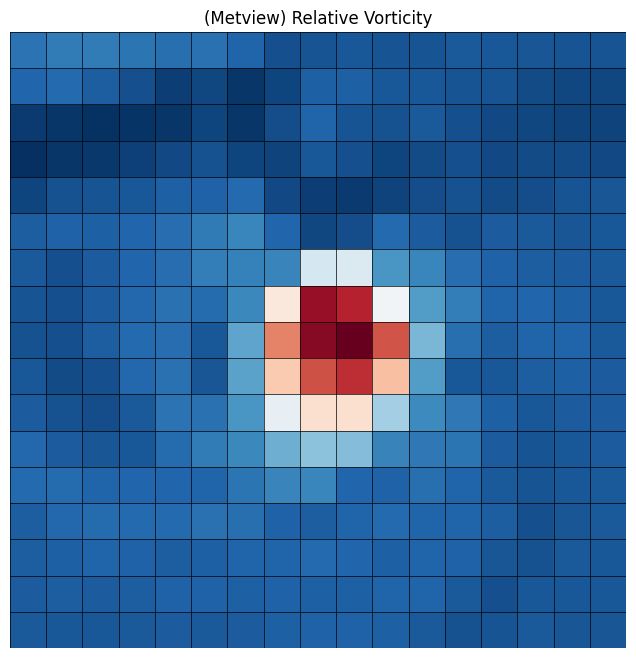

Neighborhood RV min (** 10^-5 / s): -213.07815331965685
Neighborhood RV max (** 10^-5 / s): 17.040246166288853


In [42]:
grbu_path = '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_ugrd_850_mb.grib2'
grbv_path ='/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_vgrd_850_mb.grib2'

grb = pygrib.open(grbu_path)[1]
lats,lons = grb.latlons()
res = grb['iDirectionIncrementInDegrees']

ufs = mv.read(grbu_path)
vfs = mv.read(grbv_path)
vort_850 = calculate_vorticity(ufs, vfs, vorticity_method='metview')

x = int((1/res)*(90-lat))
y = int((1/res)*(0+lon))

neighborhood_size = calculate_neighborhood_size(2, res)

#rv = masked_vort_850.filled()[0]
rv = vort_850
# Extract the neighborhood for the current candidate
x_min = x - neighborhood_size
x_max = x + neighborhood_size + 1
y_min = y - neighborhood_size
y_max = y + neighborhood_size + 1

in_bounds = ((x_min >= 0) and
    (x_max <= rv.shape[0]) and
    (y_min >= 0) and
    (y_max <= rv.shape[1]))

if in_bounds:
    # the normal case (not edges of array)
    neighborhood = rv[x_min:x_max, y_min:y_max]
else:
    # handle indices at the boundaries
    neighborhood = extract_2d_neighborhood(rv, (x, y), neighborhood_size)

#create_image(neighborhood, 'Positive | Negative Relative Vorticity')
create_image(neighborhood, '(Metview) Relative Vorticity', rv_to_sign = False)
# GEMPAK yields -213.1 (no further precision)
print("Neighborhood RV min (** 10^-5 / s):", neighborhood.min() * np.power(10.0,5))
print("Neighborhood RV max (** 10^-5 / s):", neighborhood.max() * np.power(10.0,5))

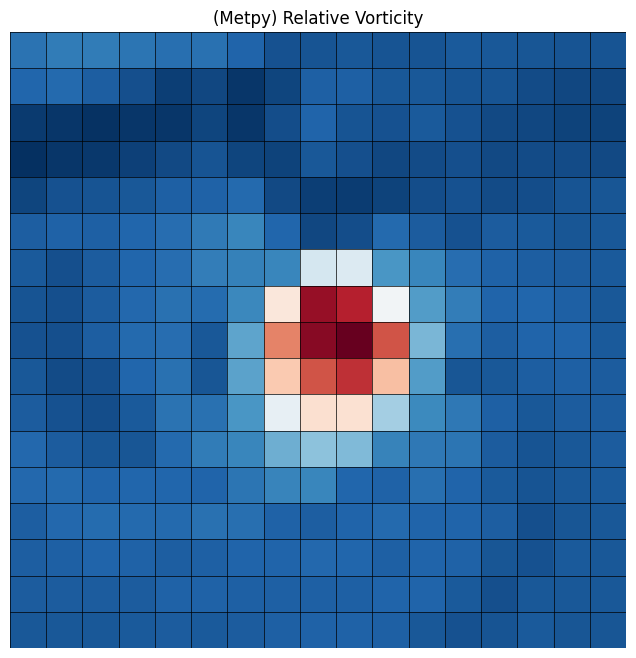

Neighborhood RV min (** 10^-5 / s): -213.0970497490504
Neighborhood RV max (** 10^-5 / s): 16.980802808308006


In [46]:
grbu_path = '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_ugrd_850_mb.grib2'
grbv_path ='/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_vgrd_850_mb.grib2'

grb = pygrib.open(grbu_path)[1]
lats,lons = grb.latlons()
res = grb['iDirectionIncrementInDegrees']

ufs = mv.read(grbu_path)
vfs = mv.read(grbv_path)

uxs = ufs.to_dataset()
for name in uxs:
    short_name = name
xu = uxs[short_name].to_numpy()

vxs = vfs.to_dataset()
for name in vxs:
    short_name = name
xv = vxs[short_name].to_numpy()

vort_850 = calculate_vorticity(xu, xv, lats, lons, vorticity_method='metpy')

x = int((1/res)*(90-lat))
y = int((1/res)*(0+lon))

neighborhood_size = calculate_neighborhood_size(2, res)

#rv = masked_vort_850.filled()[0]
rv = vort_850
# Extract the neighborhood for the current candidate
x_min = x - neighborhood_size
x_max = x + neighborhood_size + 1
y_min = y - neighborhood_size
y_max = y + neighborhood_size + 1

in_bounds = ((x_min >= 0) and
    (x_max <= rv.shape[0]) and
    (y_min >= 0) and
    (y_max <= rv.shape[1]))

if in_bounds:
    # the normal case (not edges of array)
    neighborhood = rv[x_min:x_max, y_min:y_max]
else:
    # handle indices at the boundaries
    neighborhood = extract_2d_neighborhood(rv, (x, y), neighborhood_size)

#create_image(neighborhood, 'Positive | Negative Relative Vorticity')
create_image(neighborhood, '(Metpy) Relative Vorticity', rv_to_sign = False)
# GEMPAK yields -213.1 (no further precision)
print("Neighborhood RV min (** 10^-5 / s):", neighborhood.min() * np.power(10.0,5))
print("Neighborhood RV max (** 10^-5 / s):", neighborhood.max() * np.power(10.0,5))

4
x,y 414 668


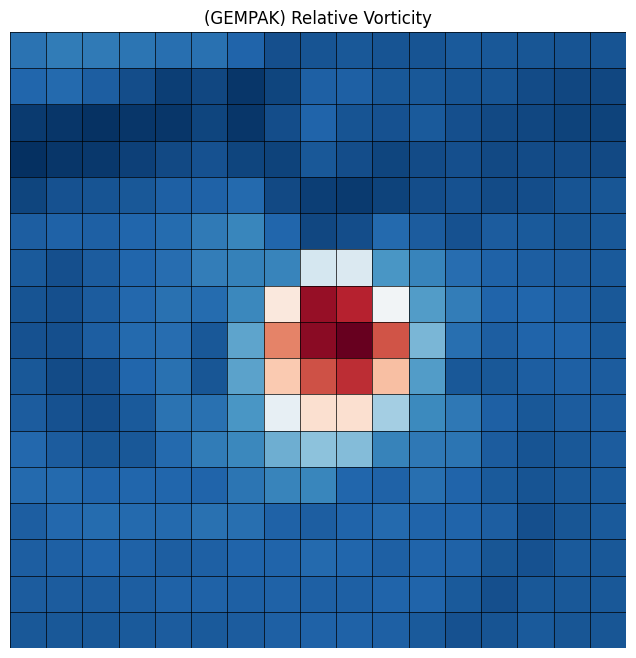

Neighborhood RV min (** 10^-5 / s): -213.1
Neighborhood RV max (** 10^-5 / s): 17.0


In [41]:
# since this is not a grib file have to set res manually
res = 0.25
gempak_out_var, scale = read_gdlist('/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_vor_850_mb.out')
out_var = gempak_out_var * 10**scale

gempack_vort = np.ma.masked_invalid(np.array(out_var))
vort_850 = gempack_vort

x = int((1/res)*(90-lat))
y = int((1/res)*(0+lon))
print('x,y',x,y)

neighborhood_size = calculate_neighborhood_size(2, res)

#rv = masked_vort_850.filled()[0]
rv = vort_850
# Extract the neighborhood for the current candidate
x_min = x - neighborhood_size
x_max = x + neighborhood_size + 1
y_min = y - neighborhood_size
y_max = y + neighborhood_size + 1

in_bounds = ((x_min >= 0) and
    (x_max <= rv.shape[0]) and
    (y_min >= 0) and
    (y_max <= rv.shape[1]))

if in_bounds:
    # the normal case (not edges of array)
    neighborhood = rv[x_min:x_max, y_min:y_max]
else:
    # handle indices at the boundaries
    neighborhood = extract_2d_neighborhood(rv, (x, y), neighborhood_size)

#create_image(neighborhood, 'Positive | Negative Relative Vorticity')
create_image(neighborhood, '(GEMPAK) Relative Vorticity', rv_to_sign = False)
# GEMPAK yields -213.1 (no further precision)
print("Neighborhood RV min (** 10^-5 / s):", neighborhood.min() * np.power(10.0,5))
print("Neighborhood RV max (** 10^-5 / s):", neighborhood.max() * np.power(10.0,5))

x,y 153 334
lat/lon for x,y -13.5 167.0


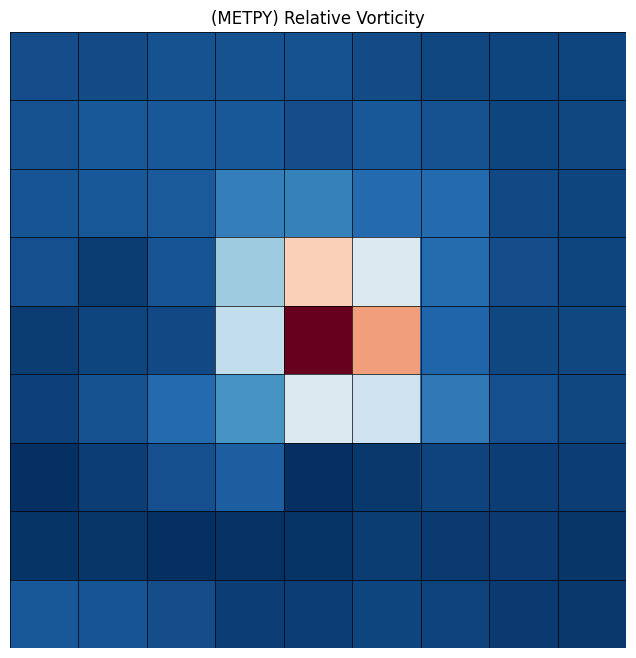

Neighborhood RV min (** 10^-5 / s): -168.7200041487813
Neighborhood RV max (** 10^-5 / s): 7.0299996878020465


In [17]:
# display the saved vort output test case
grb_vor_path = '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_vor_850_mb.grib2'

grb = pygrib.open(grb_vor_path)[1]
lats,lons = grb.latlons()
res = grb['iDirectionIncrementInDegrees']

xvor_850 = xr.open_dataset(grb_vor_path, engine="cfgrib",filter_by_keys={'typeOfLevel': 'isobaricInhPa'})

vor_fs = mv.read(grb_vor_path)

vort_850 = vor_fs.to_dataset()['vo'].to_masked_array()

# the lats's are placed in the other direction for this grib
x = int((1/res)*(90+lat))
y = int((1/res)*(0+lon))
print('x,y',x,y)
print('lat/lon for x,y', lats[x][y], lons[x,y])

neighborhood_size = calculate_neighborhood_size(2, res)

#rv = masked_vort_850.filled()[0]
rv = vort_850
# Extract the neighborhood for the current candidate
x_min = x - neighborhood_size
x_max = x + neighborhood_size + 1
y_min = y - neighborhood_size
y_max = y + neighborhood_size + 1

in_bounds = ((x_min >= 0) and
    (x_max <= rv.shape[0]) and
    (y_min >= 0) and
    (y_max <= rv.shape[1]))

if in_bounds:
    # the normal case (not edges of array)
    neighborhood = rv[x_min:x_max, y_min:y_max]
else:
    # handle indices at the boundaries
    neighborhood = extract_2d_neighborhood(rv, (x, y), neighborhood_size)

#create_image(neighborhood, 'Positive | Negative Relative Vorticity')
create_image(neighborhood, '(METPY) Relative Vorticity', rv_to_sign = False)
# GEMPAK yields: -168.72 (precision in grib set to 5 digits)
print("Neighborhood RV min (** 10^-5 / s):", neighborhood.min() * np.power(10.0,5))
print("Neighborhood RV max (** 10^-5 / s):", neighborhood.max() * np.power(10.0,5))

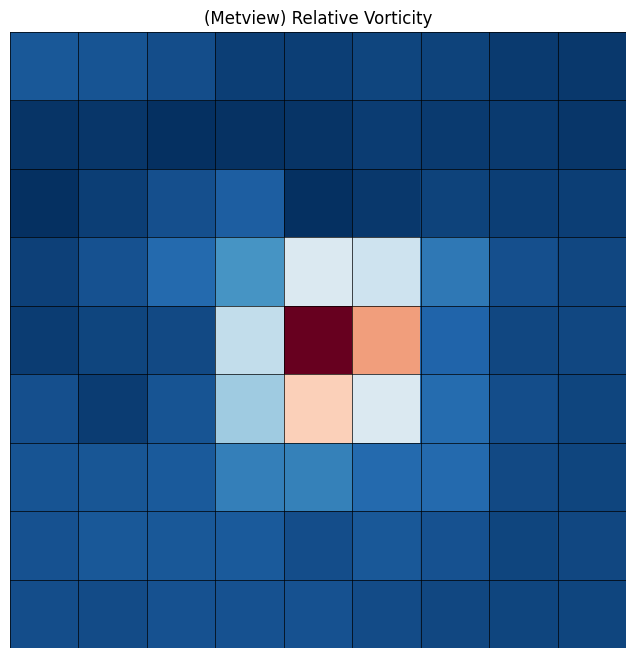

Neighborhood RV min (** 10^-5 / s): -168.72164560481906
Neighborhood RV max (** 10^-5 / s): 7.027329411357641


In [43]:
grbu_path = '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_ugrd_850_mb.grib2'
grbv_path ='/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_vgrd_850_mb.grib2'

grb = pygrib.open(grbu_path)[1]
lats,lons = grb.latlons()
res = grb['iDirectionIncrementInDegrees']

ufs = mv.read(grbu_path)
vfs = mv.read(grbv_path)
vort_850 = calculate_vorticity(ufs, vfs, vorticity_method='metview')

x = int((1/res)*(90-lat))
y = int((1/res)*(0+lon))

neighborhood_size = calculate_neighborhood_size(2, res)

#rv = masked_vort_850.filled()[0]
rv = vort_850
# Extract the neighborhood for the current candidate
x_min = x - neighborhood_size
x_max = x + neighborhood_size + 1
y_min = y - neighborhood_size
y_max = y + neighborhood_size + 1

in_bounds = ((x_min >= 0) and
    (x_max <= rv.shape[0]) and
    (y_min >= 0) and
    (y_max <= rv.shape[1]))

if in_bounds:
    # the normal case (not edges of array)
    neighborhood = rv[x_min:x_max, y_min:y_max]
else:
    # handle indices at the boundaries
    neighborhood = extract_2d_neighborhood(rv, (x, y), neighborhood_size)

#create_image(neighborhood, 'Positive | Negative Relative Vorticity')
create_image(neighborhood, '(Metview) Relative Vorticity', rv_to_sign = False)
# GEMPAK yields -213.1 (no further precision)
print("Neighborhood RV min (** 10^-5 / s):", neighborhood.min() * np.power(10.0,5))
print("Neighborhood RV max (** 10^-5 / s):", neighborhood.max() * np.power(10.0,5))

/home/db/.local/lib/python3.9/site-packages/cfgrib/xarray_to_grib.py:261: FutureWarning: GRIB write support is experimental, DO NOT RELY ON IT!
  warnings.warn("GRIB write support is experimental, DO NOT RELY ON IT!", FutureWarning)
/home/db/.local/lib/python3.9/site-packages/cfgrib/xarray_to_grib.py:261: FutureWarning: GRIB write support is experimental, DO NOT RELY ON IT!
  warnings.warn("GRIB write support is experimental, DO NOT RELY ON IT!", FutureWarning)


x,y 207 334
lat/lon for x,y -13.5 167.0


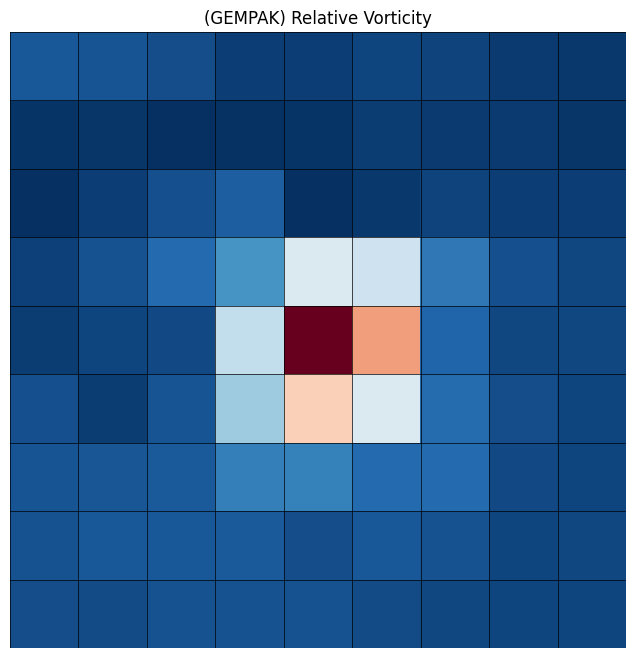

Neighborhood RV min (** 10^-5 / s): -168.72164560481906
Neighborhood RV max (** 10^-5 / s): 7.027329411357641


In [19]:
grbu_path = '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_ugrd_850_mb.grib2'
grbv_path ='/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p50.f072_vgrd_850_mb.grib2'

grb = pygrib.open(grbu_path)[1]
lats,lons = grb.latlons()
res = grb['iDirectionIncrementInDegrees']

xu_wind_850 = xr.open_dataset(grbu_path, engine="cfgrib",filter_by_keys={'typeOfLevel': 'isobaricInhPa'})
xv_wind_850 = xr.open_dataset(grbv_path, engine="cfgrib",filter_by_keys={'typeOfLevel': 'isobaricInhPa'})

ug = mv.read(grbu_path)
vg = mv.read(grbv_path)

xu = ug.to_dataset()
xv = vg.to_dataset()
vort_fieldset = mv.vorticity(xu,xv)

vort_850 = vort_fieldset.to_dataset()['vo'].to_masked_array()
masked_vort_850 = vort_850

x = int((1/res)*(90-lat))
y = int((1/res)*(0+lon))
print('x,y', x,y)
print('lat/lon for x,y', lats[x][y], lons[x,y])
neighborhood_size = calculate_neighborhood_size(2, res)

#rv = masked_vort_850.filled()[0]
rv = vort_850
# Extract the neighborhood for the current candidate
x_min = x - neighborhood_size
x_max = x + neighborhood_size + 1
y_min = y - neighborhood_size
y_max = y + neighborhood_size + 1

in_bounds = ((x_min >= 0) and
    (x_max <= rv.shape[0]) and
    (y_min >= 0) and
    (y_max <= rv.shape[1]))

if in_bounds:
    # the normal case (not edges of array)
    neighborhood = rv[x_min:x_max, y_min:y_max]
else:
    # handle indices at the boundaries
    neighborhood = extract_2d_neighborhood(rv, (x, y), neighborhood_size)

#create_image(neighborhood, 'Positive | Negative Relative Vorticity')
create_image(neighborhood, '(GEMPAK) Relative Vorticity', rv_to_sign = False)
# GEMPAK yields: -168.72 (precision in grib set to 5 digits)
print("Neighborhood RV min (** 10^-5 / s):", neighborhood.min() * np.power(10.0,5))
print("Neighborhood RV max (** 10^-5 / s):", neighborhood.max() * np.power(10.0,5))

In [ ]:
################################################################
##### TEST OF DB STORAGE/RETRIEVAL AND BULK STEP CALCULATIONS ##
################################################################

In [48]:
model_name = 'GFS'
model_timestamp_str = '2023-10-30T06:00:00'
model_time_steps = [60, 66, 72]

model_timestamp = datetime.fromisoformat(model_timestamp_str)
all_candidates = calc_disturbances_by_model_name_date_and_time_steps(model_name, model_timestamp, model_time_steps)
print("\nDone")


Done


In [368]:
# Example: retrieve disturbances for a specific set of time steps for a model run
model_name = "GFS"
model_timestamp_str = '2023-11-02T12:00:00'
time_steps = [36]

model_timestamp = datetime.fromisoformat(model_timestamp_str)
disturbance_candidates = get_disturbances_from_db(model_name, model_timestamp)
for time_step in time_steps:
    time_step_str = str(time_step)
    print("============================================")
    print("DISTURBANCES MEETING TC CRITERIA")
    print(f"{model_name} {model_timestamp} +{time_step_str}h")
    print("============================================")
    if disturbance_candidates:
        if time_step_str in disturbance_candidates:
            print_candidates(disturbance_candidates[time_step_str])
    print("")

DISTURBANCES MEETING TC CRITERIA
GFS 2023-11-02 12:00:00 +36h
# 1, AL Basin, Latitude (deg:):   16.2, Longitude (deg):  -87.5, MSLP (hPa): 1008.2, ~ROCI (km):   23
        850 RV MAX (*10^-5 1/s):  45.56, 250-850 hPa Thickness (m): 9517.93, 925 hPa WS MAX (m/s):  17.34
        10m WS MAX (m/s) in ~ROCI:  10.07, Isobar delta (hPa) (MSLP for OCI - minimum):   2
# 2, EP Basin, Latitude (deg:):   11.0, Longitude (deg): -126.0, MSLP (hPa): 1005.1, ~ROCI (km):   11
        850 RV MAX (*10^-5 1/s):  29.41, 250-850 hPa Thickness (m): 9513.53, 925 hPa WS MAX (m/s):  13.92
        10m WS MAX (m/s) in ~ROCI:   8.81, Isobar delta (hPa) (MSLP for OCI - minimum):   3
# 3, EP Basin, Latitude (deg:):   10.2, Longitude (deg): -103.8, MSLP (hPa): 1003.6, ~ROCI (km):  232
        850 RV MAX (*10^-5 1/s): 110.42, 250-850 hPa Thickness (m): 9550.15, 925 hPa WS MAX (m/s):  26.06
        10m WS MAX (m/s) in ~ROCI:  18.11, Isobar delta (hPa) (MSLP for OCI - minimum):   4
# 4, EP Basin, Latitude (deg:):    9.8

In [ ]:
#1054.1 seconds for 00Z
#969.9 seconds for 06Z

Average Radius (m): 405883.97
Average Radius (degrees): 3.73046875


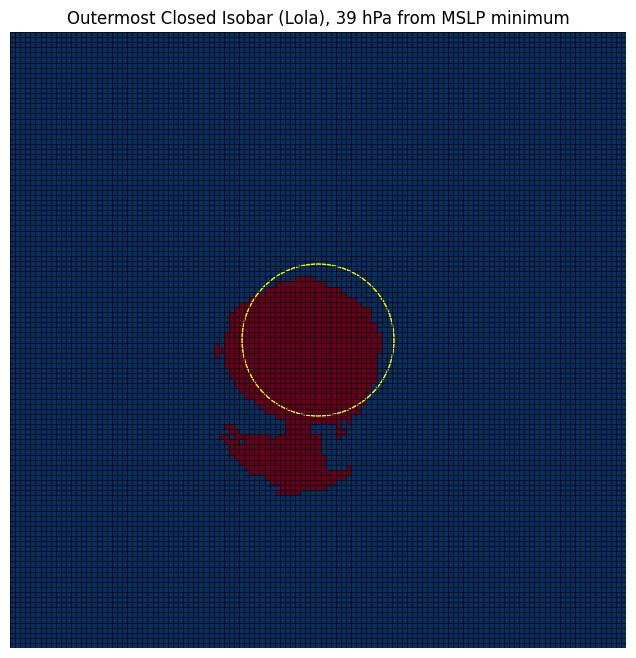

[{'x_value': 414,
  'y_value': 668,
  'roci': 405883.96875,
  'roci_grid_units': 14.921875,
  'mass_x': 414,
  'mass_y': 668,
  'closed_isobar_delta': 39}]

In [53]:
# example for calculating ROCI (based on some ideas from [4] but not the same method)
# requires metview and the mslp data as a fieldset (for the distance calculation)
# reworked example to only use metview

# Lola (2023)
lat = -13.5
lon = 167.0

grbmsl_path = '/home/db/metview/JRPdata/gfs2/gfs.t00z.pgrb2.0p25.f072_prmsl_mean_sea_level.grib2'

mslp_fs = mv.read(grbmsl_path)
# Extract relevant parameters (modify the parameter names and levels accordingly)

short_name = None
# assume only one message per grib (gribs split by param and level)
xds = mslp_fs.to_dataset()
for name in xds:
    short_name = name
xda = xds[short_name]

level = get_level_from_fieldset(fs)

res = xda.GRIB_iDirectionIncrementInDegrees
name = xda.name
values = xda.to_numpy()
units = xda.GRIB_units
lats = xda.latitude.to_numpy()
lons = xda.longitude.to_numpy()

mslp_data = values
mslp_fs = fs

# convert to hPa
if units == 'Pa':
    mslp_data = values * 0.01
else:
    mslp_data = values

x = int((1/res)*(90-lat))
y = int((1/res)*(0+lon))

# testing finding isobars

candidate = {
    'x_value': x,
    'y_value': y
}

mass_candidate, max_isobar_difference, visited = get_outermost_closed_isobar(mslp_data, res, candidate)

average_radius, average_radius_units = find_average_radius(mslp_fs, mass_candidate, visited, num_legs=576)
print("Average Radius (m):", average_radius)
print(f"Average Radius (degrees):", average_radius_units * res)

create_image(visited, f'Outermost Closed Isobar (Lola), {max_isobar_difference} hPa from MSLP minimum', rv_to_sign = True, radius = average_radius_units)

# test calc_roci()
candidate = {'x_value': x, 'y_value': y}
candidates = [candidate]
calc_roci(candidates, mslp_data, mslp_fs, res)

In [ ]:
# check answer with units
# 14.921875 grid units * (0.25 degree / 1 grid units) (60 nautical miles / degree) * (1852 meters / nautical miles)
14.921875 * (0.25) * (60) * (1852)

In [14]:
####################################
#### CHART DISTURBANCES EXAMPLE ####
####################################
# chart an entire run's disturbances (no 24 our requirement or grouping of very close MSLP minima)
model_name = "GFS"
model_timestamp_str = '2023-11-14T12:00:00'
model_timestamp = datetime.fromisoformat(model_timestamp_str)
time_steps = all_time_steps_by_model[model_name]
generate_disturbances_chart(model_name, model_timestamp, time_steps)

Map(center=[0, 200], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

In [613]:
##########################################################
#### REGULAR CELLS FOR UPDATING DISTURBANCES MANUALLY ####
##########################################################

# process all runs not already in disturbances db for single model, starting at a timestamp
model_name = "GFS"
start_model_timestamp_str = '2023-10-30T18:00:00'
start_model_timestamp = datetime.fromisoformat(start_model_timestamp_str)

# Get the current UTC time
current_time = datetime.utcnow()

# Calculate the next 6-hour interval
next_interval_hour = (current_time.hour // 6 + 1) * 6

# If the next interval is at 24:00, move it to the next day
if next_interval_hour == 24:
    next_time = current_time.replace(hour=0, minute=0, second=0, microsecond=0)
    next_time += timedelta(days=1)
    next_interval_hour = 0
else:
    next_time = current_time.replace(hour=next_interval_hour, minute=0, second=0, microsecond=0)

# If the next time is greater than or equal to the model timestamp, use it; otherwise, use the model timestamp
end_timestamp = next_time if next_time >= start_model_timestamp else start_model_timestamp

# Get the list of timestamps expected (6 hour intervals)
interval = timedelta(hours=6)
timestamps = []
current_timestamp = start_model_timestamp
while current_timestamp <= end_timestamp:
    timestamps.append(current_timestamp)
    current_timestamp += interval

for model_timestamp in timestamps:    
    print("Processing", model_name, model_timestamp)
    model_hour_str = f'{model_timestamp.hour:02}'
    time_steps = all_time_steps_by_model[model_name][model_hour_str]
    all_candidates = calc_disturbances_by_model_name_date_and_time_steps(model_name, model_timestamp, time_steps)

print("\nDone")

Processing GFS 2023-10-30 18:00:00
Processing GFS 2023-10-31 00:00:00
Processing GFS 2023-10-31 06:00:00
Processing GFS 2023-10-31 12:00:00
Processing GFS 2023-10-31 18:00:00
Processing GFS 2023-11-01 00:00:00
Processing GFS 2023-11-01 06:00:00
Processing GFS 2023-11-01 12:00:00
Processing GFS 2023-11-01 18:00:00
Processing GFS 2023-11-02 00:00:00
Processing GFS 2023-11-02 06:00:00
Processing GFS 2023-11-02 12:00:00
Processing GFS 2023-11-02 18:00:00
Processing GFS 2023-11-03 00:00:00
Processing GFS 2023-11-03 06:00:00
Processing GFS 2023-11-03 12:00:00
Processing GFS 2023-11-03 18:00:00
Processing GFS 2023-11-04 00:00:00
Processing GFS 2023-11-04 06:00:00
Processing GFS 2023-11-04 12:00:00
Processing GFS 2023-11-04 18:00:00
Processing GFS 2023-11-05 00:00:00
Processing GFS 2023-11-05 06:00:00
Processing GFS 2023-11-05 12:00:00
Processing GFS 2023-11-05 18:00:00
Processing GFS 2023-11-06 00:00:00
Processing GFS 2023-11-06 06:00:00
Processing GFS 2023-11-06 12:00:00
Processing GFS 2023-

Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 00Z at +144h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 00Z at +150h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 00Z at +156h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 00Z at +162h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 00Z at +168h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 00Z at +174h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 00Z at +180h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 00Z at +186h
Calculating Relative vorticity for 850 hPa




Calculati

Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 00Z at +312h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 00Z at +318h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 00Z at +324h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 00Z at +330h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 00Z at +336h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 00Z at +342h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 00Z at +348h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 00Z at +354h
Calculating Relative vorticity for 850 hPa




Calculati

Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 06Z at +90h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 06Z at +96h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 06Z at +102h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 06Z at +108h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 06Z at +114h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 06Z at +120h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 06Z at +126h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 06Z at +132h
Calculating Relative vorticity for 850 hPa




Calculating

Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 06Z at +258h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 06Z at +264h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 06Z at +270h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 06Z at +276h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 06Z at +282h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 06Z at +288h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 06Z at +294h
Calculating Relative vorticity for 850 hPa




Calculating disturbances (TC candidates) GFS for 20231109 06Z at +300h
Calculating Relative vorticity for 850 hPa




Calculati

In [800]:
#######################################
### CALCULATE TCs FROM DISTURBANCES ###
#######################################

# Only not already computed calculate disturbances from complete model runs
calc_tc_candidates()

Calculate TC candidates (and simplified tracks)
# Model runs to process: 1


GFS_2023-11-12T18:00:00
# components: 8
  Start Valid Time: 2023-11-12T18:00:00
    SH Basin, Latitude (deg:):  -10.0, Longitude (deg):  168.8, MSLP (hPa):  993.6, ~ROCI (km):  754
        850 RV MAX (*10^-5 1/s): -82.83, 250-850 hPa Thickness (m): 9617.20, 925 hPa WS MAX (m/s):  34.80
        10m WS MAX (knots) in ~ROCI:   46.1, Isobar delta (hPa) (MSLP for OCI - minimum):  12
  Last Valid Time: 2023-11-16T12:00:00
    SH Basin, Latitude (deg:):  -28.5, Longitude (deg): -179.2, MSLP (hPa):  992.9, ~ROCI (km):  470
        850 RV MAX (*10^-5 1/s): -67.23, 250-850 hPa Thickness (m): 9539.94, 925 hPa WS MAX (m/s):  36.14
        10m WS MAX (knots) in ~ROCI:   45.4, Isobar delta (hPa) (MSLP for OCI - minimum):  19
  Max 10m Wind Speed Valid Time: 2023-11-15T00:00:00
    SH Basin, Latitude (deg:):  -20.8, Longitude (deg):  176.8, MSLP (hPa):  981.4, ~ROCI (km):  538
        850 RV MAX (*10^-5 1/s): -130.41, 250-85

In [6]:
#################### EXAMPLES USING EXITING DATABASES

In [7]:
####### CALC ACE AND NSD FROM TC CANDIDATE TRACKS

In [10]:
for basin_name in shape_basin_names_to_threshold_names_map.values():
    print("")
    print("==============================================================================")
    print(f"{basin_name} BASIN")
    print("==============================================================================")
    recent_candidates = get_tc_candidates_by_basin(basin_name)

    # GET NSDs and ACE values
    min_kt = 34
    for storm in recent_candidates:
        model_name = storm['model_name']
        model_timestamp = storm['model_timestamp']
        start_valid_time = storm['start_valid_time']
        ws_max_10m_knots = storm['ws_max_10m'] * meters_to_knots
        disturbance_candidates = storm['disturbance_candidates']
        print(f"{model_name} Init: {model_timestamp}")
        print(f"    Start valid_time: {start_valid_time}")
        ace = 0
        nsd = 0
        last_time_step = None
        last_vmax_10m_knots = None
        first = True
        last_candidate = None
        for time_step_str, valid_time_str, candidate in disturbance_candidates:
            last_time_step = int(time_step_str)
            vmax_10m_knots = candidate['vmax10m_in_roci'] * meters_to_knots
            last_vmax_10m_knots = vmax_10m_knots
            if vmax_10m_knots >= min_kt:
                nsd += 0.25
                ace += pow(10, -4) * np.power(vmax_10m_knots, 2)
            if first:
                print_candidates([candidate], no_numbering = True)
                first = False
            last_candidate = candidate
            
        last_valid_time = (datetime.fromisoformat(start_valid_time) + timedelta(hours=last_time_step)).isoformat()
        print(f"    Last valid_time: {last_valid_time}")
        print_candidates([last_candidate], no_numbering=True)
        max_model_time_step = max_model_time_steps_from_timestamp_str(model_name, model_timestamp)
        if last_time_step == max_model_time_step:
            if last_vmax_10m_knots >= min_kt:
                print("    At/above 34kt at end of model run")
            else:
                print("    Below 34kt at end of model run")
        else:
            print("    Last disturbance is before end of model run")
        print(f"    Named Storm Days: {nsd:3.2f}")
        print(f"    ACE: {ace:3.1f}")
        print(f"    10m WS MAX (knots) in ~ROCI: {ws_max_10m_knots:3.1f}")
    
    print("")


AL BASIN
CMC Init: 2023-11-14T12:00:00
    Start valid_time: 2023-11-19T00:00:00
    AL Basin, Latitude (deg:):   15.9, Longitude (deg):  -77.1, MSLP (hPa): 1004.8, ~ROCI (km):  475
        850 RV MAX (*10^-5 1/s):  36.04, 250-850 hPa Thickness (m): 9549.36, 925 hPa WS MAX (m/s):  25.96
        10m WS MAX (knots) in ~ROCI:   35.6, Isobar delta (hPa) (MSLP for OCI - minimum):   3
    Last valid_time: 2023-11-24T18:00:00
    AL Basin, Latitude (deg:):   16.4, Longitude (deg):  -75.4, MSLP (hPa): 1005.8, ~ROCI (km):  656
        850 RV MAX (*10^-5 1/s):  32.11, 250-850 hPa Thickness (m): 9537.29, 925 hPa WS MAX (m/s):  18.18
        10m WS MAX (knots) in ~ROCI:   25.5, Isobar delta (hPa) (MSLP for OCI - minimum):   4
    Last disturbance is before end of model run
    Named Storm Days: 0.25
    ACE: 0.1
    10m WS MAX (knots) in ~ROCI: 35.6
CMC Init: 2023-11-14T12:00:00
    Start valid_time: 2023-11-22T06:00:00
    AL Basin, Latitude (deg:):   18.5, Longitude (deg):  -80.7, MSLP (hPa): 1

In [123]:
# Get the TC tracks from each model, and from the most recent N model runs

In [11]:
# most recent N model runs
num_init_times_per_model = 1
model_init_times, recent_candidates = get_tc_candidates_from_last_n_model_init_times(num_init_times_per_model)
for model_name, init_time in model_init_times.items():
    print(model_name, init_time)

GFS ['2023-11-14T12:00:00']
ECM ['2023-11-14T12:00:00']
CMC ['2023-11-14T12:00:00']
NAV ['2023-11-14T12:00:00']


In [15]:
generate_tc_chart(recent_candidates)

Map(center=[0, 200], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…